##### Copyright 2021 The TensorFlow Hub Authors. 
Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Fine tuning models for plant disease detection


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cropnet_on_device"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/cropnet_on_device.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/cropnet_on_device.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/cropnet_on_device.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=cropnet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook shows you how to **fine-tune CropNet models from TensorFlow Hub** on a dataset from TFDS or your own crop disease detection dataset.

You will:
- Load the TFDS cassava dataset or your own data
- Enrich the data with unknown (negative) examples to get a more robust model
- Apply image augmentations to the data
- Load and fine tune a [CropNet model](https://tfhub.dev/s?module-type=image-feature-vector&q=cropnet) from TF Hub
- Export a TFLite model, ready to be deployed on your app with [Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier), [MLKit](https://developers.google.com/ml-kit/vision/image-labeling/custom-models/android) or [TFLite](https://www.tensorflow.org/lite/guide/inference) directly

## Imports and Dependencies

Before starting, you'll need to install some of the dependencies that will be needed like [Model Maker](https://www.tensorflow.org/lite/guide/model_maker#installation) and the latest version of TensorFlow Datasets.

In [2]:
!sudo apt install -q libportaudio2
## image_classifier library requires numpy <= 1.23.5
!pip install "numpy<=1.23.5"
!pip install --use-deprecated=legacy-resolver tflite-model-maker-nightly
!pip install -U tensorflow-datasets
## scann library requires tensorflow < 2.9.0
!pip install "tensorflow<2.9.0"
!pip install "tensorflow-datasets~=4.8.0"  # protobuf>=3.12.2
!pip install tensorflow-metadata~=1.10.0  # protobuf>=3.13
## tensorflowjs requires packaging < 20.10
!pip install "packaging<20.10"

Reading package lists...
Building dependency tree...


Reading state information...


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0 libxmlb2
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  libportaudio2


0 upgraded, 1 newly installed, 0 to remove and 97 not upgraded.


Need to get 65.4 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://us-east1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Fetched 65.4 kB in 0s (3036 kB/s)



78

Selecting previously unselected package libportaudio2:amd64.


(Reading database ... 173592 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking libportaudio2:amd64 (19.6.0-1build1) ...
7Progress: [ 40%] [#######################...................................] 8

Setting up libportaudio2:amd64 (19.6.0-1build1) ...
7Progress: [ 60%] [##################################........................] 8

7Progress: [ 80%] [##############################################............] 8Processing triggers for libc-bin (2.31-0ubuntu9.12) ...



78

  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1


    Uninstalling numpy-1.26.1:


      Successfully uninstalled numpy-1.26.1


  Using cached sentencepiece-0.1.99-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


  Preparing metadata (setup.py) ... -

 done


  Using cached lxml-4.9.3-cp39-cp39-manylinux_2_28_x86_64.whl (8.0 MB)


  Using cached tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl (241 kB)


  Using cached Cython-3.0.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)


  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)


  Using cached google_api_python_client-2.106.0-py2.py3-none-any.whl (12.6 MB)


Processing /home/kbuilder/.cache/pip/wheels/d2/ed/a5/da3a0cfb13373d1ace41cafa4f2467d858c55c52473ba72799/kaggle-1.5.16-py3-none-any.whl (from tf-models-official==2.3.0->tflite-model-maker-nightly)


  Using cached opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.1 MB)


  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)


  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)


  Using cached httplib2-0.22.0-py3-none-any.whl (96 kB)


  Using cached google_auth_httplib2-0.1.1-py2.py3-none-any.whl (9.3 kB)


  Using cached google_api_core-2.12.0-py3-none-any.whl (121 kB)


  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)


  Using cached proto_plus-1.22.3-py3-none-any.whl (48 kB)


  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)


  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


 \

 |

 done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=d4685a762ec02e3157bb4bb11549888782f141e0164a915be5f41ed4aa0fc9e7
  Stored in directory: /home/kbuilder/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.1
    Uninstalling matplotlib-3.8.1:


      Successfully uninstalled matplotlib-3.8.1


  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.15.0
    Uninstalling tensorflow-hub-0.15.0:
      Successfully uninstalled tensorflow-hub-0.15.0


ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
scann 1.2.6 requires tensorflow~=2.8.0, but you'll have tensorflow 2.15.0rc1 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you'll have packaging 23.2 which is incompatible.


  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)


  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)


  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0


  Attempting uninstall: keras
    Found existing installation: keras 2.15.0


    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2


    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.1.0
    Uninstalling google-auth-oauthlib-1.1.0:
      Successfully uninstalled google-auth-oauthlib-1.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1


    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0rc1


    Uninstalling tensorflow-2.15.0rc1:


      Successfully uninstalled tensorflow-2.15.0rc1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you have packaging 23.2 which is incompatible.


  Using cached protobuf-3.20.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:


      Successfully uninstalled protobuf-3.19.6


  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.3


    Uninstalling tensorflow-datasets-4.9.3:
      Successfully uninstalled tensorflow-datasets-4.9.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you have packaging 23.2 which is incompatible.


  Attempting uninstall: tensorflow-metadata
    Found existing installation: tensorflow-metadata 1.14.0


    Uninstalling tensorflow-metadata-1.14.0:
      Successfully uninstalled tensorflow-metadata-1.14.0


  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.25.0 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
scikit-image 0.22.0 requires packaging>=21, but you have packaging 20.9 which is incompatible.


In [3]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing

from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker.image_classifier import ModelSpec

2023-11-07 13:39:32.174301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want 

## Load a TFDS dataset to fine-tune on

Lets use the publicly available [Cassava Leaf Disease dataset](https://www.tensorflow.org/datasets/catalog/cassava) from TFDS.

In [4]:
tfds_name = 'cassava'
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name=tfds_name,
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True)
TFLITE_NAME_PREFIX = tfds_name

2023-11-07 13:39:36.293577: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Or alternatively load your own data to fine-tune on

Instead of using a TFDS dataset, you can also train on your own data. This code snippet shows how to load your own custom dataset. See [this](https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder) link for the supported structure of the data. An example is provided here using the publicly available [Cassava Leaf Disease dataset](https://www.tensorflow.org/datasets/catalog/cassava).

In [5]:
# data_root_dir = tf.keras.utils.get_file(
#     'cassavaleafdata.zip',
#     'https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip',
#     extract=True)
# data_root_dir = os.path.splitext(data_root_dir)[0]  # Remove the .zip extension

# builder = tfds.ImageFolder(data_root_dir)

# ds_info = builder.info
# ds_train = builder.as_dataset(split='train', as_supervised=True)
# ds_validation = builder.as_dataset(split='validation', as_supervised=True)
# ds_test = builder.as_dataset(split='test', as_supervised=True)

## Visualize samples from train split

Let's take a look at some examples from the dataset including the class id and the class name for the image samples and their labels.

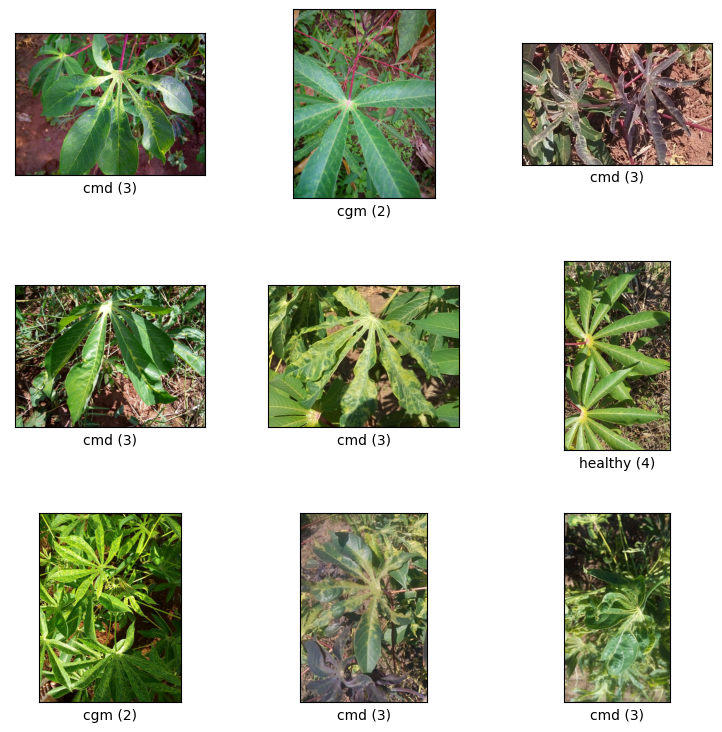

In [6]:
_ = tfds.show_examples(ds_train, ds_info)

## Add images to be used as Unknown examples from TFDS datasets

Add additional unknown (negative) examples to the training dataset and assign a new unknown class label number to them. The goal is to have a model that, when used in practice (e.g. in the field), has the option of predicting "Unknown" when it sees something unexpected.

Below you can see a list of datasets that will be used to sample the additional unknown imagery. It includes 3 completely different datasets to increase diversity. One of them is a beans leaf disease dataset, so that the model has exposure to diseased plants other than cassava.


In [7]:
UNKNOWN_TFDS_DATASETS = [{
    'tfds_name': 'imagenet_v2/matched-frequency',
    'train_split': 'test[:80%]',
    'test_split': 'test[80%:]',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'oxford_flowers102',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'beans',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}]

The UNKNOWN datasets are also loaded from TFDS.

In [8]:
# Load unknown datasets.
weights = [
    spec['num_examples_ratio_to_normal'] for spec in UNKNOWN_TFDS_DATASETS
]
num_unknown_train_examples = sum(
    int(w * ds_train.cardinality().numpy()) for w in weights)
ds_unknown_train = tf.data.Dataset.sample_from_datasets([
    tfds.load(
        name=spec['tfds_name'], split=spec['train_split'],
        as_supervised=True).repeat(-1) for spec in UNKNOWN_TFDS_DATASETS
], weights).take(num_unknown_train_examples)
ds_unknown_train = ds_unknown_train.apply(
    tf.data.experimental.assert_cardinality(num_unknown_train_examples))
ds_unknown_tests = [
    tfds.load(
        name=spec['tfds_name'], split=spec['test_split'], as_supervised=True)
    for spec in UNKNOWN_TFDS_DATASETS
]
ds_unknown_test = ds_unknown_tests[0]
for ds in ds_unknown_tests[1:]:
  ds_unknown_test = ds_unknown_test.concatenate(ds)

# All examples from the unknown datasets will get a new class label number.
num_normal_classes = len(ds_info.features['label'].names)
unknown_label_value = tf.convert_to_tensor(num_normal_classes, tf.int64)
ds_unknown_train = ds_unknown_train.map(lambda image, _:
                                        (image, unknown_label_value))
ds_unknown_test = ds_unknown_test.map(lambda image, _:
                                      (image, unknown_label_value))

# Merge the normal train dataset with the unknown train dataset.
weights = [
    ds_train.cardinality().numpy(),
    ds_unknown_train.cardinality().numpy()
]
ds_train_with_unknown = tf.data.Dataset.sample_from_datasets(
    [ds_train, ds_unknown_train], [float(w) for w in weights])
ds_train_with_unknown = ds_train_with_unknown.apply(
    tf.data.experimental.assert_cardinality(sum(weights)))

print((f"Added {ds_unknown_train.cardinality().numpy()} negative examples."
       f"Training dataset has now {ds_train_with_unknown.cardinality().numpy()}"
       ' examples in total.'))

Added 16968 negative examples.Training dataset has now 22624 examples in total.


## Apply augmentations

For all the images, to make them more diverse, you'll apply some augmentation, like changes in:
- Brightness
- Contrast
- Saturation
- Hue
- Crop

These types of augmentations help make the model more robust to variations in image inputs.


In [9]:
def random_crop_and_random_augmentations_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = image_preprocessing.preprocess_for_train(image)
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.5, 2.0)
  image = tf.image.random_saturation(image, 0.75, 1.25)
  image = tf.image.random_hue(image, 0.1)
  return image


def random_crop_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = image_preprocessing.preprocess_for_train(image)
  return image


def resize_and_center_crop_fn(image):
  image = tf.image.resize(image, (256, 256))
  image = image[16:240, 16:240]
  return image


no_augment_fn = lambda image: image

train_augment_fn = lambda image, label: (
    random_crop_and_random_augmentations_fn(image), label)
eval_augment_fn = lambda image, label: (resize_and_center_crop_fn(image), label)

To apply the augmentation, it uses the `map` method from the Dataset class.

In [10]:
ds_train_with_unknown = ds_train_with_unknown.map(train_augment_fn)
ds_validation = ds_validation.map(eval_augment_fn)
ds_test = ds_test.map(eval_augment_fn)
ds_unknown_test = ds_unknown_test.map(eval_augment_fn)

INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


## Wrap the data into Model Maker friendly format

To use these dataset with Model Maker, they need to be in a ImageClassifierDataLoader class.

In [11]:
label_names = ds_info.features['label'].names + ['UNKNOWN']

train_data = ImageClassifierDataLoader(ds_train_with_unknown,
                                       ds_train_with_unknown.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)
test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
                                      label_names)
unknown_test_data = ImageClassifierDataLoader(ds_unknown_test,
                                              ds_unknown_test.cardinality(),
                                              label_names)

## Run training

[TensorFlow Hub](https://tfhub.dev) has multiple models available for Transfer Learning.

Here you can choose one and you can also keep experimenting with other ones to try to get better results.

If you want even more models to try, you can add them from this [collection](https://tfhub.dev/google/collections/image/1).


In [12]:
#@title Choose a base model

model_name = 'mobilenet_v3_large_100_224'  #@param ['cropnet_cassava', 'cropnet_concat', 'cropnet_imagenet', 'mobilenet_v3_large_100_224']

map_model_name = {
    'cropnet_cassava':
        'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

To fine tune the model, you will use Model Maker. This  makes the overall solution easier since after the training of the model, it'll also convert it to TFLite.

Model Maker makes this conversion be the best one possible and with all the necessary information to easily deploy the model on-device later.

The model spec is how you tell Model Maker which base model you'd like to use.

In [13]:
image_model_spec = ModelSpec(uri=model_handle)

One important detail here is setting `train_whole_model` which will make the base model fine tuned during training. This makes the process slower but the final model has a higher accuracy. Setting `shuffle` will make sure the model sees the data in a random shuffled order which is a best practice for model learning.

In [14]:
model = image_classifier.create(
    train_data,
    model_spec=image_model_spec,
    batch_size=128,
    learning_rate=0.03,
    epochs=5,
    shuffle=True,
    train_whole_model=True,
    validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2 (HubKe  (None, 1280)             4226432   


 rasLayerV1V2)                                                   


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 6)                 7686      


Total params: 4,234,118


Trainable params: 4,209,718


Non-trainable params: 24,400


_________________________________________________________________


None


Epoch 1/5


  1/176 [..............................] - ETA: 47:44 - loss: 2.2828 - accuracy: 0.1406

  2/176 [..............................] - ETA: 8:14 - loss: 2.0456 - accuracy: 0.2773 

  3/176 [..............................] - ETA: 8:01 - loss: 1.8046 - accuracy: 0.4401

  4/176 [..............................] - ETA: 7:54 - loss: 1.6464 - accuracy: 0.5371

  5/176 [..............................] - ETA: 7:51 - loss: 1.6022 - accuracy: 0.5719

  6/176 [>.............................] - ETA: 7:48 - loss: 1.5415 - accuracy: 0.6042

  7/176 [>.............................] - ETA: 7:43 - loss: 1.4873 - accuracy: 0.6406

  8/176 [>.............................] - ETA: 7:37 - loss: 1.4434 - accuracy: 0.6670

  9/176 [>.............................] - ETA: 7:34 - loss: 1.4156 - accuracy: 0.6875

 10/176 [>.............................] - ETA: 7:31 - loss: 1.3861 - accuracy: 0.7070

 11/176 [>.............................] - ETA: 7:28 - loss: 1.3636 - accuracy: 0.7180

 12/176 [=>............................] - ETA: 7:24 - loss: 1.3356 - accuracy: 0.7318

 13/176 [=>............................] - ETA: 7:21 - loss: 1.3179 - accuracy: 0.7386

 14/176 [=>............................] - ETA: 7:18 - loss: 1.2943 - accuracy: 0.7500

 15/176 [=>............................] - ETA: 7:15 - loss: 1.2706 - accuracy: 0.7620

 16/176 [=>............................] - ETA: 7:11 - loss: 1.2508 - accuracy: 0.7710

 17/176 [=>............................] - ETA: 7:09 - loss: 1.2322 - accuracy: 0.7790

 18/176 [==>...........................] - ETA: 7:05 - loss: 1.2169 - accuracy: 0.7852

 19/176 [==>...........................] - ETA: 7:02 - loss: 1.2048 - accuracy: 0.7907

 20/176 [==>...........................] - ETA: 6:58 - loss: 1.1912 - accuracy: 0.7961

 21/176 [==>...........................] - ETA: 6:56 - loss: 1.1776 - accuracy: 0.8017

 22/176 [==>...........................] - ETA: 6:52 - loss: 1.1656 - accuracy: 0.8061

 23/176 [==>...........................] - ETA: 6:49 - loss: 1.1543 - accuracy: 0.8108

 24/176 [===>..........................] - ETA: 6:46 - loss: 1.1432 - accuracy: 0.8148

 25/176 [===>..........................] - ETA: 6:42 - loss: 1.1344 - accuracy: 0.8188

 26/176 [===>..........................] - ETA: 6:39 - loss: 1.1276 - accuracy: 0.8212

 27/176 [===>..........................] - ETA: 6:36 - loss: 1.1249 - accuracy: 0.8220

 28/176 [===>..........................] - ETA: 6:33 - loss: 1.1172 - accuracy: 0.8253

 29/176 [===>..........................] - ETA: 6:30 - loss: 1.1091 - accuracy: 0.8292

 30/176 [====>.........................] - ETA: 6:27 - loss: 1.1005 - accuracy: 0.8323

 31/176 [====>.........................] - ETA: 6:24 - loss: 1.0911 - accuracy: 0.8364

 32/176 [====>.........................] - ETA: 6:21 - loss: 1.0879 - accuracy: 0.8376

 33/176 [====>.........................] - ETA: 6:18 - loss: 1.0838 - accuracy: 0.8390

 34/176 [====>.........................] - ETA: 6:15 - loss: 1.0785 - accuracy: 0.8412

 35/176 [====>.........................] - ETA: 6:13 - loss: 1.0715 - accuracy: 0.8444

 36/176 [=====>........................] - ETA: 6:10 - loss: 1.0675 - accuracy: 0.8461

 37/176 [=====>........................] - ETA: 6:07 - loss: 1.0637 - accuracy: 0.8473

 38/176 [=====>........................] - ETA: 6:05 - loss: 1.0572 - accuracy: 0.8505

 39/176 [=====>........................] - ETA: 6:02 - loss: 1.0543 - accuracy: 0.8518

 40/176 [=====>........................] - ETA: 5:59 - loss: 1.0504 - accuracy: 0.8529

 41/176 [=====>........................] - ETA: 5:57 - loss: 1.0454 - accuracy: 0.8550

 42/176 [======>.......................] - ETA: 5:54 - loss: 1.0415 - accuracy: 0.8566

 43/176 [======>.......................] - ETA: 5:51 - loss: 1.0377 - accuracy: 0.8583

 44/176 [======>.......................] - ETA: 5:48 - loss: 1.0339 - accuracy: 0.8596

 45/176 [======>.......................] - ETA: 5:46 - loss: 1.0292 - accuracy: 0.8615

 46/176 [======>.......................] - ETA: 5:43 - loss: 1.0253 - accuracy: 0.8631

 47/176 [=======>......................] - ETA: 5:40 - loss: 1.0219 - accuracy: 0.8647

 48/176 [=======>......................] - ETA: 5:37 - loss: 1.0190 - accuracy: 0.8662

 49/176 [=======>......................] - ETA: 5:34 - loss: 1.0161 - accuracy: 0.8669

 50/176 [=======>......................] - ETA: 5:32 - loss: 1.0128 - accuracy: 0.8683

 51/176 [=======>......................] - ETA: 5:29 - loss: 1.0102 - accuracy: 0.8693

 52/176 [=======>......................] - ETA: 5:26 - loss: 1.0075 - accuracy: 0.8705

 53/176 [========>.....................] - ETA: 5:24 - loss: 1.0050 - accuracy: 0.8713

 54/176 [========>.....................] - ETA: 5:21 - loss: 1.0026 - accuracy: 0.8720

 55/176 [========>.....................] - ETA: 5:18 - loss: 0.9989 - accuracy: 0.8734

 56/176 [========>.....................] - ETA: 5:15 - loss: 0.9957 - accuracy: 0.8749

 57/176 [========>.....................] - ETA: 5:13 - loss: 0.9958 - accuracy: 0.8747

 58/176 [========>.....................] - ETA: 5:10 - loss: 0.9933 - accuracy: 0.8754

 59/176 [=========>....................] - ETA: 5:07 - loss: 0.9912 - accuracy: 0.8761

 60/176 [=========>....................] - ETA: 5:05 - loss: 0.9880 - accuracy: 0.8772

 61/176 [=========>....................] - ETA: 5:02 - loss: 0.9858 - accuracy: 0.8781

 62/176 [=========>....................] - ETA: 4:59 - loss: 0.9846 - accuracy: 0.8787

 63/176 [=========>....................] - ETA: 4:56 - loss: 0.9816 - accuracy: 0.8800

 64/176 [=========>....................] - ETA: 4:54 - loss: 0.9799 - accuracy: 0.8804

 65/176 [==========>...................] - ETA: 4:51 - loss: 0.9783 - accuracy: 0.8811

 66/176 [==========>...................] - ETA: 4:48 - loss: 0.9767 - accuracy: 0.8816

 67/176 [==========>...................] - ETA: 4:46 - loss: 0.9749 - accuracy: 0.8822

 68/176 [==========>...................] - ETA: 4:43 - loss: 0.9738 - accuracy: 0.8828

 69/176 [==========>...................] - ETA: 4:40 - loss: 0.9710 - accuracy: 0.8842

 70/176 [==========>...................] - ETA: 4:38 - loss: 0.9685 - accuracy: 0.8854

 71/176 [===========>..................] - ETA: 4:35 - loss: 0.9672 - accuracy: 0.8857

 72/176 [===========>..................] - ETA: 4:32 - loss: 0.9656 - accuracy: 0.8861

 73/176 [===========>..................] - ETA: 4:30 - loss: 0.9640 - accuracy: 0.8867

 74/176 [===========>..................] - ETA: 4:27 - loss: 0.9626 - accuracy: 0.8870

 75/176 [===========>..................] - ETA: 4:25 - loss: 0.9615 - accuracy: 0.8874

 76/176 [===========>..................] - ETA: 4:22 - loss: 0.9606 - accuracy: 0.8877

 77/176 [============>.................] - ETA: 4:19 - loss: 0.9589 - accuracy: 0.8885

 78/176 [============>.................] - ETA: 4:17 - loss: 0.9572 - accuracy: 0.8893

 79/176 [============>.................] - ETA: 4:14 - loss: 0.9555 - accuracy: 0.8898

 80/176 [============>.................] - ETA: 4:11 - loss: 0.9540 - accuracy: 0.8901

 81/176 [============>.................] - ETA: 4:09 - loss: 0.9531 - accuracy: 0.8904

 82/176 [============>.................] - ETA: 4:06 - loss: 0.9516 - accuracy: 0.8910

 83/176 [=============>................] - ETA: 4:03 - loss: 0.9501 - accuracy: 0.8918

 84/176 [=============>................] - ETA: 4:01 - loss: 0.9487 - accuracy: 0.8926

 85/176 [=============>................] - ETA: 3:58 - loss: 0.9482 - accuracy: 0.8927

 86/176 [=============>................] - ETA: 3:55 - loss: 0.9468 - accuracy: 0.8931

 87/176 [=============>................] - ETA: 3:53 - loss: 0.9460 - accuracy: 0.8936

 88/176 [==============>...............] - ETA: 3:50 - loss: 0.9451 - accuracy: 0.8940

 89/176 [==============>...............] - ETA: 3:47 - loss: 0.9439 - accuracy: 0.8946

 90/176 [==============>...............] - ETA: 3:45 - loss: 0.9429 - accuracy: 0.8949

 91/176 [==============>...............] - ETA: 3:42 - loss: 0.9415 - accuracy: 0.8953

 92/176 [==============>...............] - ETA: 3:39 - loss: 0.9418 - accuracy: 0.8950

 93/176 [==============>...............] - ETA: 3:37 - loss: 0.9409 - accuracy: 0.8952

 94/176 [===============>..............] - ETA: 3:34 - loss: 0.9402 - accuracy: 0.8954

 95/176 [===============>..............] - ETA: 3:31 - loss: 0.9390 - accuracy: 0.8960

 96/176 [===============>..............] - ETA: 3:29 - loss: 0.9380 - accuracy: 0.8964

 97/176 [===============>..............] - ETA: 3:26 - loss: 0.9365 - accuracy: 0.8971

 98/176 [===============>..............] - ETA: 3:23 - loss: 0.9359 - accuracy: 0.8973

 99/176 [===============>..............] - ETA: 3:21 - loss: 0.9350 - accuracy: 0.8978

100/176 [================>.............] - ETA: 3:18 - loss: 0.9335 - accuracy: 0.8985

101/176 [================>.............] - ETA: 3:16 - loss: 0.9325 - accuracy: 0.8988

102/176 [================>.............] - ETA: 3:13 - loss: 0.9318 - accuracy: 0.8992

103/176 [================>.............] - ETA: 3:10 - loss: 0.9309 - accuracy: 0.8995

104/176 [================>.............] - ETA: 3:08 - loss: 0.9301 - accuracy: 0.8996

105/176 [================>.............] - ETA: 3:05 - loss: 0.9295 - accuracy: 0.8999

106/176 [=================>............] - ETA: 3:02 - loss: 0.9286 - accuracy: 0.9001

107/176 [=================>............] - ETA: 3:00 - loss: 0.9283 - accuracy: 0.9001

108/176 [=================>............] - ETA: 2:57 - loss: 0.9275 - accuracy: 0.9005

109/176 [=================>............] - ETA: 2:55 - loss: 0.9263 - accuracy: 0.9009

110/176 [=================>............] - ETA: 2:52 - loss: 0.9252 - accuracy: 0.9013

111/176 [=================>............] - ETA: 2:49 - loss: 0.9245 - accuracy: 0.9015

112/176 [==================>...........] - ETA: 2:47 - loss: 0.9240 - accuracy: 0.9018

113/176 [==================>...........] - ETA: 2:44 - loss: 0.9230 - accuracy: 0.9022

114/176 [==================>...........] - ETA: 2:41 - loss: 0.9215 - accuracy: 0.9030

115/176 [==================>...........] - ETA: 2:39 - loss: 0.9202 - accuracy: 0.9035

116/176 [==================>...........] - ETA: 2:36 - loss: 0.9192 - accuracy: 0.9040

117/176 [==================>...........] - ETA: 2:34 - loss: 0.9180 - accuracy: 0.9045

118/176 [===================>..........] - ETA: 2:31 - loss: 0.9166 - accuracy: 0.9051

119/176 [===================>..........] - ETA: 2:28 - loss: 0.9160 - accuracy: 0.9053

120/176 [===================>..........] - ETA: 2:26 - loss: 0.9154 - accuracy: 0.9057

121/176 [===================>..........] - ETA: 2:23 - loss: 0.9146 - accuracy: 0.9059

122/176 [===================>..........] - ETA: 2:20 - loss: 0.9144 - accuracy: 0.9060

123/176 [===================>..........] - ETA: 2:18 - loss: 0.9132 - accuracy: 0.9064

124/176 [====================>.........] - ETA: 2:15 - loss: 0.9125 - accuracy: 0.9067

125/176 [====================>.........] - ETA: 2:13 - loss: 0.9115 - accuracy: 0.9070

126/176 [====================>.........] - ETA: 2:10 - loss: 0.9111 - accuracy: 0.9072

127/176 [====================>.........] - ETA: 2:07 - loss: 0.9102 - accuracy: 0.9076

128/176 [====================>.........] - ETA: 2:05 - loss: 0.9095 - accuracy: 0.9080

129/176 [====================>.........] - ETA: 2:02 - loss: 0.9087 - accuracy: 0.9084

130/176 [=====================>........] - ETA: 2:00 - loss: 0.9081 - accuracy: 0.9087

131/176 [=====================>........] - ETA: 1:57 - loss: 0.9078 - accuracy: 0.9088

132/176 [=====================>........] - ETA: 1:54 - loss: 0.9069 - accuracy: 0.9093

133/176 [=====================>........] - ETA: 1:52 - loss: 0.9060 - accuracy: 0.9096

134/176 [=====================>........] - ETA: 1:49 - loss: 0.9053 - accuracy: 0.9097

135/176 [======================>.......] - ETA: 1:47 - loss: 0.9044 - accuracy: 0.9102

136/176 [======================>.......] - ETA: 1:44 - loss: 0.9042 - accuracy: 0.9102

137/176 [======================>.......] - ETA: 1:41 - loss: 0.9036 - accuracy: 0.9105

138/176 [======================>.......] - ETA: 1:39 - loss: 0.9032 - accuracy: 0.9107

139/176 [======================>.......] - ETA: 1:36 - loss: 0.9029 - accuracy: 0.9109

140/176 [======================>.......] - ETA: 1:33 - loss: 0.9024 - accuracy: 0.9111

141/176 [=======================>......] - ETA: 1:31 - loss: 0.9014 - accuracy: 0.9115

142/176 [=======================>......] - ETA: 1:28 - loss: 0.9007 - accuracy: 0.9118

143/176 [=======================>......] - ETA: 1:26 - loss: 0.9000 - accuracy: 0.9122

144/176 [=======================>......] - ETA: 1:23 - loss: 0.9000 - accuracy: 0.9121

145/176 [=======================>......] - ETA: 1:20 - loss: 0.8992 - accuracy: 0.9124

146/176 [=======================>......] - ETA: 1:18 - loss: 0.8988 - accuracy: 0.9123

147/176 [========================>.....] - ETA: 1:15 - loss: 0.8985 - accuracy: 0.9125

148/176 [========================>.....] - ETA: 1:13 - loss: 0.8978 - accuracy: 0.9128

149/176 [========================>.....] - ETA: 1:10 - loss: 0.8972 - accuracy: 0.9130

150/176 [========================>.....] - ETA: 1:07 - loss: 0.8964 - accuracy: 0.9133

151/176 [========================>.....] - ETA: 1:05 - loss: 0.8960 - accuracy: 0.9134

152/176 [========================>.....] - ETA: 1:02 - loss: 0.8957 - accuracy: 0.9136

153/176 [=========================>....] - ETA: 59s - loss: 0.8953 - accuracy: 0.9139 

154/176 [=========================>....] - ETA: 57s - loss: 0.8950 - accuracy: 0.9141

155/176 [=========================>....] - ETA: 54s - loss: 0.8945 - accuracy: 0.9142

156/176 [=========================>....] - ETA: 52s - loss: 0.8938 - accuracy: 0.9146

157/176 [=========================>....] - ETA: 49s - loss: 0.8932 - accuracy: 0.9148

158/176 [=========================>....] - ETA: 46s - loss: 0.8932 - accuracy: 0.9148

159/176 [==========================>...] - ETA: 44s - loss: 0.8926 - accuracy: 0.9148

160/176 [==========================>...] - ETA: 41s - loss: 0.8922 - accuracy: 0.9150

161/176 [==========================>...] - ETA: 39s - loss: 0.8919 - accuracy: 0.9152

162/176 [==========================>...] - ETA: 36s - loss: 0.8913 - accuracy: 0.9154

163/176 [==========================>...] - ETA: 33s - loss: 0.8910 - accuracy: 0.9155

164/176 [==========================>...] - ETA: 31s - loss: 0.8908 - accuracy: 0.9155

165/176 [===========================>..] - ETA: 28s - loss: 0.8903 - accuracy: 0.9157

166/176 [===========================>..] - ETA: 26s - loss: 0.8899 - accuracy: 0.9159

167/176 [===========================>..] - ETA: 23s - loss: 0.8895 - accuracy: 0.9161

168/176 [===========================>..] - ETA: 20s - loss: 0.8891 - accuracy: 0.9162

169/176 [===========================>..] - ETA: 18s - loss: 0.8885 - accuracy: 0.9166

170/176 [===========================>..] - ETA: 15s - loss: 0.8877 - accuracy: 0.9169

171/176 [============================>.] - ETA: 13s - loss: 0.8870 - accuracy: 0.9173

172/176 [============================>.] - ETA: 10s - loss: 0.8861 - accuracy: 0.9177

173/176 [============================>.] - ETA: 7s - loss: 0.8853 - accuracy: 0.9180 

174/176 [============================>.] - ETA: 5s - loss: 0.8846 - accuracy: 0.9183

175/176 [============================>.] - ETA: 2s - loss: 0.8839 - accuracy: 0.9186

176/176 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.9190

176/176 [==============================] - 485s 3s/step - loss: 0.8830 - accuracy: 0.9190 - val_loss: 1.1238 - val_accuracy: 0.8068


Epoch 2/5


  1/176 [..............................] - ETA: 17:11 - loss: 0.7976 - accuracy: 0.9609

  2/176 [..............................] - ETA: 7:32 - loss: 0.8117 - accuracy: 0.9492 

  3/176 [..............................] - ETA: 7:28 - loss: 0.8428 - accuracy: 0.9297

  4/176 [..............................] - ETA: 7:22 - loss: 0.8251 - accuracy: 0.9375

  5/176 [..............................] - ETA: 7:18 - loss: 0.8302 - accuracy: 0.9375

  6/176 [>.............................] - ETA: 7:15 - loss: 0.8199 - accuracy: 0.9427

  7/176 [>.............................] - ETA: 7:11 - loss: 0.8106 - accuracy: 0.9475

  8/176 [>.............................] - ETA: 7:10 - loss: 0.8108 - accuracy: 0.9482

  9/176 [>.............................] - ETA: 7:09 - loss: 0.8114 - accuracy: 0.9497

 10/176 [>.............................] - ETA: 7:06 - loss: 0.8096 - accuracy: 0.9508

 11/176 [>.............................] - ETA: 7:04 - loss: 0.8108 - accuracy: 0.9503

 12/176 [=>............................] - ETA: 7:01 - loss: 0.8138 - accuracy: 0.9486

 13/176 [=>............................] - ETA: 6:58 - loss: 0.8115 - accuracy: 0.9489

 14/176 [=>............................] - ETA: 6:56 - loss: 0.8093 - accuracy: 0.9509

 15/176 [=>............................] - ETA: 6:54 - loss: 0.8084 - accuracy: 0.9521

 16/176 [=>............................] - ETA: 6:51 - loss: 0.8057 - accuracy: 0.9531

 17/176 [=>............................] - ETA: 6:48 - loss: 0.8109 - accuracy: 0.9517

 18/176 [==>...........................] - ETA: 6:45 - loss: 0.8081 - accuracy: 0.9527

 19/176 [==>...........................] - ETA: 6:43 - loss: 0.8091 - accuracy: 0.9523

 20/176 [==>...........................] - ETA: 6:40 - loss: 0.8077 - accuracy: 0.9527

 21/176 [==>...........................] - ETA: 6:37 - loss: 0.8086 - accuracy: 0.9520

 22/176 [==>...........................] - ETA: 6:35 - loss: 0.8066 - accuracy: 0.9528

 23/176 [==>...........................] - ETA: 6:32 - loss: 0.8050 - accuracy: 0.9528

 24/176 [===>..........................] - ETA: 6:30 - loss: 0.8054 - accuracy: 0.9525

 25/176 [===>..........................] - ETA: 6:27 - loss: 0.8060 - accuracy: 0.9522

 26/176 [===>..........................] - ETA: 6:25 - loss: 0.8070 - accuracy: 0.9516

 27/176 [===>..........................] - ETA: 6:22 - loss: 0.8076 - accuracy: 0.9511

 28/176 [===>..........................] - ETA: 6:19 - loss: 0.8057 - accuracy: 0.9515

 29/176 [===>..........................] - ETA: 6:17 - loss: 0.8051 - accuracy: 0.9515

 30/176 [====>.........................] - ETA: 6:14 - loss: 0.8057 - accuracy: 0.9510

 31/176 [====>.........................] - ETA: 6:11 - loss: 0.8054 - accuracy: 0.9509

 32/176 [====>.........................] - ETA: 6:09 - loss: 0.8043 - accuracy: 0.9514

 33/176 [====>.........................] - ETA: 6:06 - loss: 0.8058 - accuracy: 0.9510

 34/176 [====>.........................] - ETA: 6:04 - loss: 0.8061 - accuracy: 0.9506

 35/176 [====>.........................] - ETA: 6:01 - loss: 0.8063 - accuracy: 0.9502

 36/176 [=====>........................] - ETA: 5:59 - loss: 0.8066 - accuracy: 0.9501

 37/176 [=====>........................] - ETA: 5:56 - loss: 0.8063 - accuracy: 0.9495

 38/176 [=====>........................] - ETA: 5:53 - loss: 0.8049 - accuracy: 0.9502

 39/176 [=====>........................] - ETA: 5:51 - loss: 0.8057 - accuracy: 0.9495

 40/176 [=====>........................] - ETA: 5:48 - loss: 0.8043 - accuracy: 0.9500

 41/176 [=====>........................] - ETA: 5:46 - loss: 0.8049 - accuracy: 0.9493

 42/176 [======>.......................] - ETA: 5:43 - loss: 0.8040 - accuracy: 0.9494

 43/176 [======>.......................] - ETA: 5:40 - loss: 0.8051 - accuracy: 0.9486

 44/176 [======>.......................] - ETA: 5:37 - loss: 0.8054 - accuracy: 0.9483

 45/176 [======>.......................] - ETA: 5:35 - loss: 0.8045 - accuracy: 0.9486

 46/176 [======>.......................] - ETA: 5:32 - loss: 0.8036 - accuracy: 0.9490

 47/176 [=======>......................] - ETA: 5:30 - loss: 0.8040 - accuracy: 0.9490

 48/176 [=======>......................] - ETA: 5:28 - loss: 0.8040 - accuracy: 0.9484

 49/176 [=======>......................] - ETA: 5:25 - loss: 0.8041 - accuracy: 0.9482

 50/176 [=======>......................] - ETA: 5:22 - loss: 0.8035 - accuracy: 0.9486

 51/176 [=======>......................] - ETA: 5:20 - loss: 0.8029 - accuracy: 0.9490

 52/176 [=======>......................] - ETA: 5:17 - loss: 0.8019 - accuracy: 0.9495

 53/176 [========>.....................] - ETA: 5:15 - loss: 0.8024 - accuracy: 0.9496

 54/176 [========>.....................] - ETA: 5:12 - loss: 0.8037 - accuracy: 0.9489

 55/176 [========>.....................] - ETA: 5:09 - loss: 0.8026 - accuracy: 0.9494

 56/176 [========>.....................] - ETA: 5:07 - loss: 0.8014 - accuracy: 0.9499

 57/176 [========>.....................] - ETA: 5:04 - loss: 0.8013 - accuracy: 0.9497

 58/176 [========>.....................] - ETA: 5:02 - loss: 0.8014 - accuracy: 0.9498

 59/176 [=========>....................] - ETA: 4:59 - loss: 0.8016 - accuracy: 0.9497

 60/176 [=========>....................] - ETA: 4:56 - loss: 0.8009 - accuracy: 0.9500

 61/176 [=========>....................] - ETA: 4:54 - loss: 0.8012 - accuracy: 0.9495

 62/176 [=========>....................] - ETA: 4:51 - loss: 0.8006 - accuracy: 0.9497

 63/176 [=========>....................] - ETA: 4:49 - loss: 0.8013 - accuracy: 0.9494

 64/176 [=========>....................] - ETA: 4:46 - loss: 0.8010 - accuracy: 0.9495

 65/176 [==========>...................] - ETA: 4:44 - loss: 0.8010 - accuracy: 0.9494

 66/176 [==========>...................] - ETA: 4:41 - loss: 0.8012 - accuracy: 0.9497

 67/176 [==========>...................] - ETA: 4:38 - loss: 0.8007 - accuracy: 0.9499

 68/176 [==========>...................] - ETA: 4:36 - loss: 0.8003 - accuracy: 0.9501

 69/176 [==========>...................] - ETA: 4:33 - loss: 0.8005 - accuracy: 0.9500

 70/176 [==========>...................] - ETA: 4:31 - loss: 0.8001 - accuracy: 0.9502

 71/176 [===========>..................] - ETA: 4:28 - loss: 0.7996 - accuracy: 0.9506

 72/176 [===========>..................] - ETA: 4:25 - loss: 0.7995 - accuracy: 0.9505

 73/176 [===========>..................] - ETA: 4:23 - loss: 0.7996 - accuracy: 0.9503

 74/176 [===========>..................] - ETA: 4:20 - loss: 0.7995 - accuracy: 0.9503

 75/176 [===========>..................] - ETA: 4:18 - loss: 0.7993 - accuracy: 0.9503

 76/176 [===========>..................] - ETA: 4:15 - loss: 0.7989 - accuracy: 0.9506

 77/176 [============>.................] - ETA: 4:13 - loss: 0.7987 - accuracy: 0.9507

 78/176 [============>.................] - ETA: 4:10 - loss: 0.7993 - accuracy: 0.9506

 79/176 [============>.................] - ETA: 4:08 - loss: 0.7989 - accuracy: 0.9509

 80/176 [============>.................] - ETA: 4:05 - loss: 0.7987 - accuracy: 0.9511

 81/176 [============>.................] - ETA: 4:02 - loss: 0.7987 - accuracy: 0.9511

 82/176 [============>.................] - ETA: 4:00 - loss: 0.7984 - accuracy: 0.9511

 83/176 [=============>................] - ETA: 3:57 - loss: 0.7990 - accuracy: 0.9509

 84/176 [=============>................] - ETA: 3:55 - loss: 0.7987 - accuracy: 0.9511

 85/176 [=============>................] - ETA: 3:52 - loss: 0.7986 - accuracy: 0.9509

 86/176 [=============>................] - ETA: 3:50 - loss: 0.7983 - accuracy: 0.9512

 87/176 [=============>................] - ETA: 3:47 - loss: 0.7982 - accuracy: 0.9511

 88/176 [==============>...............] - ETA: 3:44 - loss: 0.7984 - accuracy: 0.9509

 89/176 [==============>...............] - ETA: 3:42 - loss: 0.7978 - accuracy: 0.9511

 90/176 [==============>...............] - ETA: 3:39 - loss: 0.7979 - accuracy: 0.9513

 91/176 [==============>...............] - ETA: 3:37 - loss: 0.7982 - accuracy: 0.9510

 92/176 [==============>...............] - ETA: 3:34 - loss: 0.7980 - accuracy: 0.9511

 93/176 [==============>...............] - ETA: 3:32 - loss: 0.7977 - accuracy: 0.9512

 94/176 [===============>..............] - ETA: 3:29 - loss: 0.7980 - accuracy: 0.9511

 95/176 [===============>..............] - ETA: 3:27 - loss: 0.7976 - accuracy: 0.9513

 96/176 [===============>..............] - ETA: 3:24 - loss: 0.7978 - accuracy: 0.9513

 97/176 [===============>..............] - ETA: 3:21 - loss: 0.7977 - accuracy: 0.9515

 98/176 [===============>..............] - ETA: 3:19 - loss: 0.7973 - accuracy: 0.9516

 99/176 [===============>..............] - ETA: 3:16 - loss: 0.7976 - accuracy: 0.9514

100/176 [================>.............] - ETA: 3:14 - loss: 0.7971 - accuracy: 0.9516

101/176 [================>.............] - ETA: 3:11 - loss: 0.7973 - accuracy: 0.9515

102/176 [================>.............] - ETA: 3:09 - loss: 0.7969 - accuracy: 0.9517

103/176 [================>.............] - ETA: 3:06 - loss: 0.7965 - accuracy: 0.9519

104/176 [================>.............] - ETA: 3:04 - loss: 0.7960 - accuracy: 0.9521

105/176 [================>.............] - ETA: 3:01 - loss: 0.7958 - accuracy: 0.9522

106/176 [=================>............] - ETA: 2:59 - loss: 0.7959 - accuracy: 0.9522

107/176 [=================>............] - ETA: 2:56 - loss: 0.7959 - accuracy: 0.9520

108/176 [=================>............] - ETA: 2:53 - loss: 0.7960 - accuracy: 0.9519

109/176 [=================>............] - ETA: 2:51 - loss: 0.7966 - accuracy: 0.9515

110/176 [=================>............] - ETA: 2:48 - loss: 0.7966 - accuracy: 0.9514

111/176 [=================>............] - ETA: 2:46 - loss: 0.7962 - accuracy: 0.9516

112/176 [==================>...........] - ETA: 2:43 - loss: 0.7962 - accuracy: 0.9517

113/176 [==================>...........] - ETA: 2:41 - loss: 0.7962 - accuracy: 0.9517

114/176 [==================>...........] - ETA: 2:38 - loss: 0.7960 - accuracy: 0.9518

115/176 [==================>...........] - ETA: 2:35 - loss: 0.7958 - accuracy: 0.9518

116/176 [==================>...........] - ETA: 2:33 - loss: 0.7958 - accuracy: 0.9517

117/176 [==================>...........] - ETA: 2:30 - loss: 0.7955 - accuracy: 0.9517

118/176 [===================>..........] - ETA: 2:28 - loss: 0.7948 - accuracy: 0.9521

119/176 [===================>..........] - ETA: 2:25 - loss: 0.7946 - accuracy: 0.9521

120/176 [===================>..........] - ETA: 2:23 - loss: 0.7943 - accuracy: 0.9522

121/176 [===================>..........] - ETA: 2:20 - loss: 0.7941 - accuracy: 0.9524

122/176 [===================>..........] - ETA: 2:17 - loss: 0.7943 - accuracy: 0.9524

123/176 [===================>..........] - ETA: 2:15 - loss: 0.7946 - accuracy: 0.9522

124/176 [====================>.........] - ETA: 2:12 - loss: 0.7942 - accuracy: 0.9524

125/176 [====================>.........] - ETA: 2:10 - loss: 0.7937 - accuracy: 0.9528

126/176 [====================>.........] - ETA: 2:07 - loss: 0.7935 - accuracy: 0.9529

127/176 [====================>.........] - ETA: 2:05 - loss: 0.7936 - accuracy: 0.9528

128/176 [====================>.........] - ETA: 2:02 - loss: 0.7932 - accuracy: 0.9530

129/176 [====================>.........] - ETA: 2:00 - loss: 0.7929 - accuracy: 0.9532

130/176 [=====================>........] - ETA: 1:57 - loss: 0.7928 - accuracy: 0.9532

131/176 [=====================>........] - ETA: 1:55 - loss: 0.7926 - accuracy: 0.9532

132/176 [=====================>........] - ETA: 1:52 - loss: 0.7929 - accuracy: 0.9530

133/176 [=====================>........] - ETA: 1:49 - loss: 0.7925 - accuracy: 0.9532

134/176 [=====================>........] - ETA: 1:47 - loss: 0.7920 - accuracy: 0.9534

135/176 [======================>.......] - ETA: 1:44 - loss: 0.7918 - accuracy: 0.9535

136/176 [======================>.......] - ETA: 1:42 - loss: 0.7923 - accuracy: 0.9534

137/176 [======================>.......] - ETA: 1:39 - loss: 0.7920 - accuracy: 0.9536

138/176 [======================>.......] - ETA: 1:37 - loss: 0.7920 - accuracy: 0.9536

139/176 [======================>.......] - ETA: 1:34 - loss: 0.7918 - accuracy: 0.9537

140/176 [======================>.......] - ETA: 1:32 - loss: 0.7915 - accuracy: 0.9538

141/176 [=======================>......] - ETA: 1:29 - loss: 0.7911 - accuracy: 0.9539

142/176 [=======================>......] - ETA: 1:26 - loss: 0.7912 - accuracy: 0.9538

143/176 [=======================>......] - ETA: 1:24 - loss: 0.7908 - accuracy: 0.9540

144/176 [=======================>......] - ETA: 1:21 - loss: 0.7905 - accuracy: 0.9541

145/176 [=======================>......] - ETA: 1:19 - loss: 0.7905 - accuracy: 0.9540

146/176 [=======================>......] - ETA: 1:16 - loss: 0.7901 - accuracy: 0.9542

147/176 [========================>.....] - ETA: 1:14 - loss: 0.7902 - accuracy: 0.9541

148/176 [========================>.....] - ETA: 1:11 - loss: 0.7901 - accuracy: 0.9541

149/176 [========================>.....] - ETA: 1:09 - loss: 0.7900 - accuracy: 0.9541

150/176 [========================>.....] - ETA: 1:06 - loss: 0.7897 - accuracy: 0.9542

151/176 [========================>.....] - ETA: 1:03 - loss: 0.7894 - accuracy: 0.9544

152/176 [========================>.....] - ETA: 1:01 - loss: 0.7894 - accuracy: 0.9544

153/176 [=========================>....] - ETA: 58s - loss: 0.7892 - accuracy: 0.9545 

154/176 [=========================>....] - ETA: 56s - loss: 0.7890 - accuracy: 0.9546

155/176 [=========================>....] - ETA: 53s - loss: 0.7888 - accuracy: 0.9546

156/176 [=========================>....] - ETA: 51s - loss: 0.7888 - accuracy: 0.9547

157/176 [=========================>....] - ETA: 48s - loss: 0.7886 - accuracy: 0.9547

158/176 [=========================>....] - ETA: 46s - loss: 0.7890 - accuracy: 0.9547

159/176 [==========================>...] - ETA: 43s - loss: 0.7889 - accuracy: 0.9546

160/176 [==========================>...] - ETA: 40s - loss: 0.7891 - accuracy: 0.9544

161/176 [==========================>...] - ETA: 38s - loss: 0.7890 - accuracy: 0.9546

162/176 [==========================>...] - ETA: 35s - loss: 0.7889 - accuracy: 0.9548

163/176 [==========================>...] - ETA: 33s - loss: 0.7887 - accuracy: 0.9548

164/176 [==========================>...] - ETA: 30s - loss: 0.7883 - accuracy: 0.9550

165/176 [===========================>..] - ETA: 28s - loss: 0.7879 - accuracy: 0.9553

166/176 [===========================>..] - ETA: 25s - loss: 0.7881 - accuracy: 0.9551

167/176 [===========================>..] - ETA: 22s - loss: 0.7878 - accuracy: 0.9552

168/176 [===========================>..] - ETA: 20s - loss: 0.7877 - accuracy: 0.9553

169/176 [===========================>..] - ETA: 17s - loss: 0.7878 - accuracy: 0.9553

170/176 [===========================>..] - ETA: 15s - loss: 0.7875 - accuracy: 0.9554

171/176 [============================>.] - ETA: 12s - loss: 0.7874 - accuracy: 0.9555

172/176 [============================>.] - ETA: 10s - loss: 0.7873 - accuracy: 0.9554

173/176 [============================>.] - ETA: 7s - loss: 0.7875 - accuracy: 0.9552 

174/176 [============================>.] - ETA: 5s - loss: 0.7879 - accuracy: 0.9550

175/176 [============================>.] - ETA: 2s - loss: 0.7887 - accuracy: 0.9546

176/176 [==============================] - ETA: 0s - loss: 0.7892 - accuracy: 0.9545

176/176 [==============================] - 463s 3s/step - loss: 0.7892 - accuracy: 0.9545 - val_loss: 1.0590 - val_accuracy: 0.8290


Epoch 3/5


  1/176 [..............................] - ETA: 19:00 - loss: 0.7906 - accuracy: 0.9531

  2/176 [..............................] - ETA: 7:21 - loss: 0.7796 - accuracy: 0.9570 

  3/176 [..............................] - ETA: 7:24 - loss: 0.7916 - accuracy: 0.9531

  4/176 [..............................] - ETA: 7:22 - loss: 0.7770 - accuracy: 0.9629

  5/176 [..............................] - ETA: 7:17 - loss: 0.7787 - accuracy: 0.9641

  6/176 [>.............................] - ETA: 7:13 - loss: 0.7737 - accuracy: 0.9674

  7/176 [>.............................] - ETA: 7:09 - loss: 0.7735 - accuracy: 0.9665

  8/176 [>.............................] - ETA: 7:06 - loss: 0.7746 - accuracy: 0.9648

  9/176 [>.............................] - ETA: 7:05 - loss: 0.7771 - accuracy: 0.9635

 10/176 [>.............................] - ETA: 7:02 - loss: 0.7821 - accuracy: 0.9617

 11/176 [>.............................] - ETA: 6:59 - loss: 0.7847 - accuracy: 0.9609

 12/176 [=>............................] - ETA: 6:57 - loss: 0.7860 - accuracy: 0.9590

 13/176 [=>............................] - ETA: 6:54 - loss: 0.7860 - accuracy: 0.9591

 14/176 [=>............................] - ETA: 6:52 - loss: 0.7874 - accuracy: 0.9576

 15/176 [=>............................] - ETA: 6:51 - loss: 0.7890 - accuracy: 0.9573

 16/176 [=>............................] - ETA: 6:49 - loss: 0.7887 - accuracy: 0.9575

 17/176 [=>............................] - ETA: 6:46 - loss: 0.7857 - accuracy: 0.9586

 18/176 [==>...........................] - ETA: 6:43 - loss: 0.7864 - accuracy: 0.9583

 19/176 [==>...........................] - ETA: 6:41 - loss: 0.7910 - accuracy: 0.9560

 20/176 [==>...........................] - ETA: 6:39 - loss: 0.7930 - accuracy: 0.9551

 21/176 [==>...........................] - ETA: 6:36 - loss: 0.7936 - accuracy: 0.9554

 22/176 [==>...........................] - ETA: 6:33 - loss: 0.7941 - accuracy: 0.9542

 23/176 [==>...........................] - ETA: 6:31 - loss: 0.7958 - accuracy: 0.9531

 24/176 [===>..........................] - ETA: 6:28 - loss: 0.7955 - accuracy: 0.9531

 25/176 [===>..........................] - ETA: 6:25 - loss: 0.7960 - accuracy: 0.9534

 26/176 [===>..........................] - ETA: 6:23 - loss: 0.7961 - accuracy: 0.9540

 27/176 [===>..........................] - ETA: 6:20 - loss: 0.7943 - accuracy: 0.9549

 28/176 [===>..........................] - ETA: 6:18 - loss: 0.7929 - accuracy: 0.9554

 29/176 [===>..........................] - ETA: 6:15 - loss: 0.7920 - accuracy: 0.9558

 30/176 [====>.........................] - ETA: 6:13 - loss: 0.7919 - accuracy: 0.9555

 31/176 [====>.........................] - ETA: 6:10 - loss: 0.7901 - accuracy: 0.9564

 32/176 [====>.........................] - ETA: 6:08 - loss: 0.7909 - accuracy: 0.9561

 33/176 [====>.........................] - ETA: 6:05 - loss: 0.7914 - accuracy: 0.9557

 34/176 [====>.........................] - ETA: 6:03 - loss: 0.7920 - accuracy: 0.9554

 35/176 [====>.........................] - ETA: 6:00 - loss: 0.7921 - accuracy: 0.9551

 36/176 [=====>........................] - ETA: 5:58 - loss: 0.7915 - accuracy: 0.9557

 37/176 [=====>........................] - ETA: 5:55 - loss: 0.7907 - accuracy: 0.9561

 38/176 [=====>........................] - ETA: 5:53 - loss: 0.7895 - accuracy: 0.9564

 39/176 [=====>........................] - ETA: 5:50 - loss: 0.7891 - accuracy: 0.9561

 40/176 [=====>........................] - ETA: 5:47 - loss: 0.7890 - accuracy: 0.9561

 41/176 [=====>........................] - ETA: 5:45 - loss: 0.7880 - accuracy: 0.9564

 42/176 [======>.......................] - ETA: 5:42 - loss: 0.7869 - accuracy: 0.9567

 43/176 [======>.......................] - ETA: 5:39 - loss: 0.7859 - accuracy: 0.9568

 44/176 [======>.......................] - ETA: 5:37 - loss: 0.7860 - accuracy: 0.9569

 45/176 [======>.......................] - ETA: 5:34 - loss: 0.7857 - accuracy: 0.9568

 46/176 [======>.......................] - ETA: 5:32 - loss: 0.7857 - accuracy: 0.9569

 47/176 [=======>......................] - ETA: 5:29 - loss: 0.7858 - accuracy: 0.9569

 48/176 [=======>......................] - ETA: 5:27 - loss: 0.7852 - accuracy: 0.9574

 49/176 [=======>......................] - ETA: 5:24 - loss: 0.7850 - accuracy: 0.9571

 50/176 [=======>......................] - ETA: 5:22 - loss: 0.7836 - accuracy: 0.9578

 51/176 [=======>......................] - ETA: 5:19 - loss: 0.7848 - accuracy: 0.9568

 52/176 [=======>......................] - ETA: 5:16 - loss: 0.7852 - accuracy: 0.9566

 53/176 [========>.....................] - ETA: 5:14 - loss: 0.7860 - accuracy: 0.9561

 54/176 [========>.....................] - ETA: 5:11 - loss: 0.7858 - accuracy: 0.9560

 55/176 [========>.....................] - ETA: 5:09 - loss: 0.7852 - accuracy: 0.9563

 56/176 [========>.....................] - ETA: 5:06 - loss: 0.7850 - accuracy: 0.9562

 57/176 [========>.....................] - ETA: 5:04 - loss: 0.7844 - accuracy: 0.9564

 58/176 [========>.....................] - ETA: 5:01 - loss: 0.7842 - accuracy: 0.9565

 59/176 [=========>....................] - ETA: 4:58 - loss: 0.7846 - accuracy: 0.9560

 60/176 [=========>....................] - ETA: 4:56 - loss: 0.7848 - accuracy: 0.9560

 61/176 [=========>....................] - ETA: 4:53 - loss: 0.7845 - accuracy: 0.9559

 62/176 [=========>....................] - ETA: 4:51 - loss: 0.7837 - accuracy: 0.9563

 63/176 [=========>....................] - ETA: 4:48 - loss: 0.7836 - accuracy: 0.9561

 64/176 [=========>....................] - ETA: 4:46 - loss: 0.7840 - accuracy: 0.9557

 65/176 [==========>...................] - ETA: 4:43 - loss: 0.7847 - accuracy: 0.9553

 66/176 [==========>...................] - ETA: 4:41 - loss: 0.7839 - accuracy: 0.9556

 67/176 [==========>...................] - ETA: 4:38 - loss: 0.7836 - accuracy: 0.9558

 68/176 [==========>...................] - ETA: 4:35 - loss: 0.7839 - accuracy: 0.9555

 69/176 [==========>...................] - ETA: 4:33 - loss: 0.7839 - accuracy: 0.9555

 70/176 [==========>...................] - ETA: 4:30 - loss: 0.7841 - accuracy: 0.9554

 71/176 [===========>..................] - ETA: 4:28 - loss: 0.7842 - accuracy: 0.9554

 72/176 [===========>..................] - ETA: 4:25 - loss: 0.7842 - accuracy: 0.9556

 73/176 [===========>..................] - ETA: 4:22 - loss: 0.7839 - accuracy: 0.9558

 74/176 [===========>..................] - ETA: 4:20 - loss: 0.7831 - accuracy: 0.9562

 75/176 [===========>..................] - ETA: 4:17 - loss: 0.7828 - accuracy: 0.9565

 76/176 [===========>..................] - ETA: 4:15 - loss: 0.7829 - accuracy: 0.9562

 77/176 [============>.................] - ETA: 4:12 - loss: 0.7822 - accuracy: 0.9565

 78/176 [============>.................] - ETA: 4:10 - loss: 0.7820 - accuracy: 0.9564

 79/176 [============>.................] - ETA: 4:07 - loss: 0.7825 - accuracy: 0.9561

 80/176 [============>.................] - ETA: 4:05 - loss: 0.7827 - accuracy: 0.9561

 81/176 [============>.................] - ETA: 4:02 - loss: 0.7819 - accuracy: 0.9564

 82/176 [============>.................] - ETA: 4:00 - loss: 0.7819 - accuracy: 0.9564

 83/176 [=============>................] - ETA: 3:57 - loss: 0.7822 - accuracy: 0.9559

 84/176 [=============>................] - ETA: 3:54 - loss: 0.7819 - accuracy: 0.9558

 85/176 [=============>................] - ETA: 3:52 - loss: 0.7820 - accuracy: 0.9558

 86/176 [=============>................] - ETA: 3:49 - loss: 0.7815 - accuracy: 0.9559

 87/176 [=============>................] - ETA: 3:47 - loss: 0.7816 - accuracy: 0.9558

 88/176 [==============>...............] - ETA: 3:44 - loss: 0.7815 - accuracy: 0.9559

 89/176 [==============>...............] - ETA: 3:41 - loss: 0.7814 - accuracy: 0.9559

 90/176 [==============>...............] - ETA: 3:39 - loss: 0.7816 - accuracy: 0.9557

 91/176 [==============>...............] - ETA: 3:36 - loss: 0.7816 - accuracy: 0.9557

 92/176 [==============>...............] - ETA: 3:34 - loss: 0.7814 - accuracy: 0.9557

 93/176 [==============>...............] - ETA: 3:31 - loss: 0.7810 - accuracy: 0.9558

 94/176 [===============>..............] - ETA: 3:29 - loss: 0.7807 - accuracy: 0.9560

 95/176 [===============>..............] - ETA: 3:26 - loss: 0.7807 - accuracy: 0.9560

 96/176 [===============>..............] - ETA: 3:24 - loss: 0.7814 - accuracy: 0.9558

 97/176 [===============>..............] - ETA: 3:21 - loss: 0.7810 - accuracy: 0.9560

 98/176 [===============>..............] - ETA: 3:19 - loss: 0.7807 - accuracy: 0.9562

 99/176 [===============>..............] - ETA: 3:16 - loss: 0.7807 - accuracy: 0.9562

100/176 [================>.............] - ETA: 3:14 - loss: 0.7803 - accuracy: 0.9563

101/176 [================>.............] - ETA: 3:11 - loss: 0.7800 - accuracy: 0.9564

102/176 [================>.............] - ETA: 3:08 - loss: 0.7800 - accuracy: 0.9563

103/176 [================>.............] - ETA: 3:06 - loss: 0.7802 - accuracy: 0.9562

104/176 [================>.............] - ETA: 3:03 - loss: 0.7805 - accuracy: 0.9560

105/176 [================>.............] - ETA: 3:01 - loss: 0.7801 - accuracy: 0.9562

106/176 [=================>............] - ETA: 2:58 - loss: 0.7799 - accuracy: 0.9561

107/176 [=================>............] - ETA: 2:56 - loss: 0.7803 - accuracy: 0.9560

108/176 [=================>............] - ETA: 2:53 - loss: 0.7800 - accuracy: 0.9562

109/176 [=================>............] - ETA: 2:51 - loss: 0.7800 - accuracy: 0.9560

110/176 [=================>............] - ETA: 2:48 - loss: 0.7801 - accuracy: 0.9560

111/176 [=================>............] - ETA: 2:45 - loss: 0.7800 - accuracy: 0.9560

112/176 [==================>...........] - ETA: 2:43 - loss: 0.7801 - accuracy: 0.9558

113/176 [==================>...........] - ETA: 2:40 - loss: 0.7802 - accuracy: 0.9558

114/176 [==================>...........] - ETA: 2:38 - loss: 0.7800 - accuracy: 0.9558

115/176 [==================>...........] - ETA: 2:35 - loss: 0.7793 - accuracy: 0.9562

116/176 [==================>...........] - ETA: 2:33 - loss: 0.7788 - accuracy: 0.9564

117/176 [==================>...........] - ETA: 2:30 - loss: 0.7786 - accuracy: 0.9565

118/176 [===================>..........] - ETA: 2:28 - loss: 0.7785 - accuracy: 0.9565

119/176 [===================>..........] - ETA: 2:25 - loss: 0.7781 - accuracy: 0.9567

120/176 [===================>..........] - ETA: 2:22 - loss: 0.7782 - accuracy: 0.9568

121/176 [===================>..........] - ETA: 2:20 - loss: 0.7781 - accuracy: 0.9567

122/176 [===================>..........] - ETA: 2:17 - loss: 0.7781 - accuracy: 0.9566

123/176 [===================>..........] - ETA: 2:15 - loss: 0.7779 - accuracy: 0.9567

124/176 [====================>.........] - ETA: 2:12 - loss: 0.7778 - accuracy: 0.9567

125/176 [====================>.........] - ETA: 2:10 - loss: 0.7780 - accuracy: 0.9566

126/176 [====================>.........] - ETA: 2:07 - loss: 0.7786 - accuracy: 0.9564

127/176 [====================>.........] - ETA: 2:05 - loss: 0.7784 - accuracy: 0.9564

128/176 [====================>.........] - ETA: 2:02 - loss: 0.7784 - accuracy: 0.9565

129/176 [====================>.........] - ETA: 2:00 - loss: 0.7784 - accuracy: 0.9566

130/176 [=====================>........] - ETA: 1:57 - loss: 0.7786 - accuracy: 0.9564

131/176 [=====================>........] - ETA: 1:54 - loss: 0.7784 - accuracy: 0.9564

132/176 [=====================>........] - ETA: 1:52 - loss: 0.7781 - accuracy: 0.9566

133/176 [=====================>........] - ETA: 1:49 - loss: 0.7779 - accuracy: 0.9566

134/176 [=====================>........] - ETA: 1:47 - loss: 0.7779 - accuracy: 0.9567

135/176 [======================>.......] - ETA: 1:44 - loss: 0.7777 - accuracy: 0.9567

136/176 [======================>.......] - ETA: 1:42 - loss: 0.7774 - accuracy: 0.9569

137/176 [======================>.......] - ETA: 1:39 - loss: 0.7771 - accuracy: 0.9571

138/176 [======================>.......] - ETA: 1:37 - loss: 0.7770 - accuracy: 0.9570

139/176 [======================>.......] - ETA: 1:34 - loss: 0.7771 - accuracy: 0.9569

140/176 [======================>.......] - ETA: 1:31 - loss: 0.7769 - accuracy: 0.9570

141/176 [=======================>......] - ETA: 1:29 - loss: 0.7767 - accuracy: 0.9571

142/176 [=======================>......] - ETA: 1:26 - loss: 0.7762 - accuracy: 0.9573

143/176 [=======================>......] - ETA: 1:24 - loss: 0.7761 - accuracy: 0.9574

144/176 [=======================>......] - ETA: 1:21 - loss: 0.7763 - accuracy: 0.9574

145/176 [=======================>......] - ETA: 1:19 - loss: 0.7762 - accuracy: 0.9574

146/176 [=======================>......] - ETA: 1:16 - loss: 0.7761 - accuracy: 0.9574

147/176 [========================>.....] - ETA: 1:14 - loss: 0.7758 - accuracy: 0.9574

148/176 [========================>.....] - ETA: 1:11 - loss: 0.7760 - accuracy: 0.9572

149/176 [========================>.....] - ETA: 1:09 - loss: 0.7758 - accuracy: 0.9573

150/176 [========================>.....] - ETA: 1:06 - loss: 0.7755 - accuracy: 0.9574

151/176 [========================>.....] - ETA: 1:03 - loss: 0.7756 - accuracy: 0.9573

152/176 [========================>.....] - ETA: 1:01 - loss: 0.7754 - accuracy: 0.9574

153/176 [=========================>....] - ETA: 58s - loss: 0.7754 - accuracy: 0.9574 

154/176 [=========================>....] - ETA: 56s - loss: 0.7754 - accuracy: 0.9575

155/176 [=========================>....] - ETA: 53s - loss: 0.7759 - accuracy: 0.9572

156/176 [=========================>....] - ETA: 51s - loss: 0.7756 - accuracy: 0.9573

157/176 [=========================>....] - ETA: 48s - loss: 0.7754 - accuracy: 0.9574

158/176 [=========================>....] - ETA: 46s - loss: 0.7751 - accuracy: 0.9575

159/176 [==========================>...] - ETA: 43s - loss: 0.7751 - accuracy: 0.9575

160/176 [==========================>...] - ETA: 40s - loss: 0.7753 - accuracy: 0.9575

161/176 [==========================>...] - ETA: 38s - loss: 0.7749 - accuracy: 0.9577

162/176 [==========================>...] - ETA: 35s - loss: 0.7750 - accuracy: 0.9578

163/176 [==========================>...] - ETA: 33s - loss: 0.7746 - accuracy: 0.9579

164/176 [==========================>...] - ETA: 30s - loss: 0.7747 - accuracy: 0.9578

165/176 [===========================>..] - ETA: 28s - loss: 0.7746 - accuracy: 0.9579

166/176 [===========================>..] - ETA: 25s - loss: 0.7745 - accuracy: 0.9579

167/176 [===========================>..] - ETA: 23s - loss: 0.7745 - accuracy: 0.9579

168/176 [===========================>..] - ETA: 20s - loss: 0.7745 - accuracy: 0.9578

169/176 [===========================>..] - ETA: 17s - loss: 0.7745 - accuracy: 0.9577

170/176 [===========================>..] - ETA: 15s - loss: 0.7748 - accuracy: 0.9575

171/176 [============================>.] - ETA: 12s - loss: 0.7749 - accuracy: 0.9574

172/176 [============================>.] - ETA: 10s - loss: 0.7747 - accuracy: 0.9575

173/176 [============================>.] - ETA: 7s - loss: 0.7746 - accuracy: 0.9576 

174/176 [============================>.] - ETA: 5s - loss: 0.7745 - accuracy: 0.9576

175/176 [============================>.] - ETA: 2s - loss: 0.7746 - accuracy: 0.9576

176/176 [==============================] - ETA: 0s - loss: 0.7744 - accuracy: 0.9577

176/176 [==============================] - 464s 3s/step - loss: 0.7744 - accuracy: 0.9577 - val_loss: 1.0222 - val_accuracy: 0.8438


Epoch 4/5


  1/176 [..............................] - ETA: 17:39 - loss: 0.7992 - accuracy: 0.9297

  2/176 [..............................] - ETA: 7:31 - loss: 0.7953 - accuracy: 0.9375 

  3/176 [..............................] - ETA: 7:23 - loss: 0.8171 - accuracy: 0.9271

  4/176 [..............................] - ETA: 7:21 - loss: 0.8309 - accuracy: 0.9277

  5/176 [..............................] - ETA: 7:16 - loss: 0.8094 - accuracy: 0.9406

  6/176 [>.............................] - ETA: 7:12 - loss: 0.8001 - accuracy: 0.9466

  7/176 [>.............................] - ETA: 7:09 - loss: 0.7964 - accuracy: 0.9475

  8/176 [>.............................] - ETA: 7:07 - loss: 0.7928 - accuracy: 0.9482

  9/176 [>.............................] - ETA: 7:06 - loss: 0.7976 - accuracy: 0.9453

 10/176 [>.............................] - ETA: 7:05 - loss: 0.7965 - accuracy: 0.9469

 11/176 [>.............................] - ETA: 7:03 - loss: 0.7936 - accuracy: 0.9467

 12/176 [=>............................] - ETA: 7:00 - loss: 0.7908 - accuracy: 0.9486

 13/176 [=>............................] - ETA: 6:57 - loss: 0.7890 - accuracy: 0.9495

 14/176 [=>............................] - ETA: 6:55 - loss: 0.7891 - accuracy: 0.9487

 15/176 [=>............................] - ETA: 6:52 - loss: 0.7901 - accuracy: 0.9495

 16/176 [=>............................] - ETA: 6:50 - loss: 0.7880 - accuracy: 0.9507

 17/176 [=>............................] - ETA: 6:47 - loss: 0.7868 - accuracy: 0.9517

 18/176 [==>...........................] - ETA: 6:44 - loss: 0.7869 - accuracy: 0.9523

 19/176 [==>...........................] - ETA: 6:41 - loss: 0.7842 - accuracy: 0.9531

 20/176 [==>...........................] - ETA: 6:39 - loss: 0.7828 - accuracy: 0.9539

 21/176 [==>...........................] - ETA: 6:36 - loss: 0.7847 - accuracy: 0.9531

 22/176 [==>...........................] - ETA: 6:33 - loss: 0.7822 - accuracy: 0.9542

 23/176 [==>...........................] - ETA: 6:30 - loss: 0.7820 - accuracy: 0.9541

 24/176 [===>..........................] - ETA: 6:28 - loss: 0.7815 - accuracy: 0.9541

 25/176 [===>..........................] - ETA: 6:25 - loss: 0.7832 - accuracy: 0.9541

 26/176 [===>..........................] - ETA: 6:22 - loss: 0.7823 - accuracy: 0.9543

 27/176 [===>..........................] - ETA: 6:20 - loss: 0.7830 - accuracy: 0.9540

 28/176 [===>..........................] - ETA: 6:17 - loss: 0.7813 - accuracy: 0.9551

 29/176 [===>..........................] - ETA: 6:15 - loss: 0.7818 - accuracy: 0.9553

 30/176 [====>.........................] - ETA: 6:12 - loss: 0.7817 - accuracy: 0.9555

 31/176 [====>.........................] - ETA: 6:09 - loss: 0.7830 - accuracy: 0.9549

 32/176 [====>.........................] - ETA: 6:07 - loss: 0.7827 - accuracy: 0.9548

 33/176 [====>.........................] - ETA: 6:04 - loss: 0.7812 - accuracy: 0.9555

 34/176 [====>.........................] - ETA: 6:02 - loss: 0.7815 - accuracy: 0.9547

 35/176 [====>.........................] - ETA: 5:59 - loss: 0.7807 - accuracy: 0.9554

 36/176 [=====>........................] - ETA: 5:56 - loss: 0.7812 - accuracy: 0.9551

 37/176 [=====>........................] - ETA: 5:54 - loss: 0.7808 - accuracy: 0.9557

 38/176 [=====>........................] - ETA: 5:51 - loss: 0.7805 - accuracy: 0.9558

 39/176 [=====>........................] - ETA: 5:49 - loss: 0.7801 - accuracy: 0.9557

 40/176 [=====>........................] - ETA: 5:46 - loss: 0.7799 - accuracy: 0.9561

 41/176 [=====>........................] - ETA: 5:44 - loss: 0.7790 - accuracy: 0.9566

 42/176 [======>.......................] - ETA: 5:41 - loss: 0.7781 - accuracy: 0.9568

 43/176 [======>.......................] - ETA: 5:39 - loss: 0.7780 - accuracy: 0.9569

 44/176 [======>.......................] - ETA: 5:36 - loss: 0.7771 - accuracy: 0.9576

 45/176 [======>.......................] - ETA: 5:34 - loss: 0.7767 - accuracy: 0.9575

 46/176 [======>.......................] - ETA: 5:31 - loss: 0.7769 - accuracy: 0.9574

 47/176 [=======>......................] - ETA: 5:29 - loss: 0.7768 - accuracy: 0.9571

 48/176 [=======>......................] - ETA: 5:26 - loss: 0.7777 - accuracy: 0.9567

 49/176 [=======>......................] - ETA: 5:23 - loss: 0.7767 - accuracy: 0.9570

 50/176 [=======>......................] - ETA: 5:21 - loss: 0.7762 - accuracy: 0.9575

 51/176 [=======>......................] - ETA: 5:19 - loss: 0.7760 - accuracy: 0.9576

 52/176 [=======>......................] - ETA: 5:16 - loss: 0.7756 - accuracy: 0.9579

 53/176 [========>.....................] - ETA: 5:13 - loss: 0.7754 - accuracy: 0.9578

 54/176 [========>.....................] - ETA: 5:11 - loss: 0.7749 - accuracy: 0.9580

 55/176 [========>.....................] - ETA: 5:08 - loss: 0.7753 - accuracy: 0.9577

 56/176 [========>.....................] - ETA: 5:06 - loss: 0.7766 - accuracy: 0.9573

 57/176 [========>.....................] - ETA: 5:03 - loss: 0.7763 - accuracy: 0.9572

 58/176 [========>.....................] - ETA: 5:01 - loss: 0.7756 - accuracy: 0.9574

 59/176 [=========>....................] - ETA: 4:58 - loss: 0.7749 - accuracy: 0.9576

 60/176 [=========>....................] - ETA: 4:56 - loss: 0.7746 - accuracy: 0.9577

 61/176 [=========>....................] - ETA: 4:53 - loss: 0.7745 - accuracy: 0.9575

 62/176 [=========>....................] - ETA: 4:51 - loss: 0.7741 - accuracy: 0.9578

 63/176 [=========>....................] - ETA: 4:48 - loss: 0.7740 - accuracy: 0.9581

 64/176 [=========>....................] - ETA: 4:46 - loss: 0.7740 - accuracy: 0.9581

 65/176 [==========>...................] - ETA: 4:43 - loss: 0.7743 - accuracy: 0.9579

 66/176 [==========>...................] - ETA: 4:41 - loss: 0.7742 - accuracy: 0.9580

 67/176 [==========>...................] - ETA: 4:38 - loss: 0.7746 - accuracy: 0.9578

 68/176 [==========>...................] - ETA: 4:36 - loss: 0.7740 - accuracy: 0.9582

 69/176 [==========>...................] - ETA: 4:33 - loss: 0.7738 - accuracy: 0.9583

 70/176 [==========>...................] - ETA: 4:31 - loss: 0.7738 - accuracy: 0.9585

 71/176 [===========>..................] - ETA: 4:28 - loss: 0.7734 - accuracy: 0.9587

 72/176 [===========>..................] - ETA: 4:26 - loss: 0.7731 - accuracy: 0.9589

 73/176 [===========>..................] - ETA: 4:23 - loss: 0.7732 - accuracy: 0.9588

 74/176 [===========>..................] - ETA: 4:21 - loss: 0.7730 - accuracy: 0.9588

 75/176 [===========>..................] - ETA: 4:18 - loss: 0.7722 - accuracy: 0.9592

 76/176 [===========>..................] - ETA: 4:16 - loss: 0.7727 - accuracy: 0.9592

 77/176 [============>.................] - ETA: 4:13 - loss: 0.7719 - accuracy: 0.9596

 78/176 [============>.................] - ETA: 4:10 - loss: 0.7720 - accuracy: 0.9596

 79/176 [============>.................] - ETA: 4:08 - loss: 0.7725 - accuracy: 0.9595

 80/176 [============>.................] - ETA: 4:05 - loss: 0.7732 - accuracy: 0.9592

 81/176 [============>.................] - ETA: 4:03 - loss: 0.7738 - accuracy: 0.9590

 82/176 [============>.................] - ETA: 4:00 - loss: 0.7732 - accuracy: 0.9593

 83/176 [=============>................] - ETA: 3:58 - loss: 0.7726 - accuracy: 0.9596

 84/176 [=============>................] - ETA: 3:55 - loss: 0.7726 - accuracy: 0.9594

 85/176 [=============>................] - ETA: 3:53 - loss: 0.7727 - accuracy: 0.9595

 86/176 [=============>................] - ETA: 3:50 - loss: 0.7721 - accuracy: 0.9597

 87/176 [=============>................] - ETA: 3:48 - loss: 0.7724 - accuracy: 0.9595

 88/176 [==============>...............] - ETA: 3:45 - loss: 0.7723 - accuracy: 0.9596

 89/176 [==============>...............] - ETA: 3:42 - loss: 0.7724 - accuracy: 0.9593

 90/176 [==============>...............] - ETA: 3:40 - loss: 0.7720 - accuracy: 0.9594

 91/176 [==============>...............] - ETA: 3:37 - loss: 0.7719 - accuracy: 0.9595

 92/176 [==============>...............] - ETA: 3:35 - loss: 0.7724 - accuracy: 0.9592

 93/176 [==============>...............] - ETA: 3:32 - loss: 0.7721 - accuracy: 0.9593

 94/176 [===============>..............] - ETA: 3:30 - loss: 0.7716 - accuracy: 0.9595

 95/176 [===============>..............] - ETA: 3:27 - loss: 0.7713 - accuracy: 0.9595

 96/176 [===============>..............] - ETA: 3:24 - loss: 0.7709 - accuracy: 0.9596

 97/176 [===============>..............] - ETA: 3:22 - loss: 0.7704 - accuracy: 0.9600

 98/176 [===============>..............] - ETA: 3:19 - loss: 0.7699 - accuracy: 0.9602

 99/176 [===============>..............] - ETA: 3:17 - loss: 0.7710 - accuracy: 0.9598

100/176 [================>.............] - ETA: 3:14 - loss: 0.7715 - accuracy: 0.9595

101/176 [================>.............] - ETA: 3:12 - loss: 0.7714 - accuracy: 0.9595

102/176 [================>.............] - ETA: 3:09 - loss: 0.7713 - accuracy: 0.9596

103/176 [================>.............] - ETA: 3:06 - loss: 0.7715 - accuracy: 0.9596

104/176 [================>.............] - ETA: 3:04 - loss: 0.7720 - accuracy: 0.9591

105/176 [================>.............] - ETA: 3:01 - loss: 0.7715 - accuracy: 0.9594

106/176 [=================>............] - ETA: 2:59 - loss: 0.7716 - accuracy: 0.9593

107/176 [=================>............] - ETA: 2:56 - loss: 0.7710 - accuracy: 0.9597

108/176 [=================>............] - ETA: 2:54 - loss: 0.7707 - accuracy: 0.9599

109/176 [=================>............] - ETA: 2:51 - loss: 0.7708 - accuracy: 0.9597

110/176 [=================>............] - ETA: 2:49 - loss: 0.7705 - accuracy: 0.9597

111/176 [=================>............] - ETA: 2:46 - loss: 0.7702 - accuracy: 0.9598

112/176 [==================>...........] - ETA: 2:43 - loss: 0.7703 - accuracy: 0.9597

113/176 [==================>...........] - ETA: 2:41 - loss: 0.7699 - accuracy: 0.9599

114/176 [==================>...........] - ETA: 2:38 - loss: 0.7697 - accuracy: 0.9600

115/176 [==================>...........] - ETA: 2:36 - loss: 0.7692 - accuracy: 0.9602

116/176 [==================>...........] - ETA: 2:33 - loss: 0.7690 - accuracy: 0.9602

117/176 [==================>...........] - ETA: 2:31 - loss: 0.7687 - accuracy: 0.9602

118/176 [===================>..........] - ETA: 2:28 - loss: 0.7687 - accuracy: 0.9601

119/176 [===================>..........] - ETA: 2:25 - loss: 0.7686 - accuracy: 0.9601

120/176 [===================>..........] - ETA: 2:23 - loss: 0.7687 - accuracy: 0.9602

121/176 [===================>..........] - ETA: 2:20 - loss: 0.7684 - accuracy: 0.9602

122/176 [===================>..........] - ETA: 2:18 - loss: 0.7682 - accuracy: 0.9604

123/176 [===================>..........] - ETA: 2:15 - loss: 0.7683 - accuracy: 0.9604

124/176 [====================>.........] - ETA: 2:13 - loss: 0.7684 - accuracy: 0.9604

125/176 [====================>.........] - ETA: 2:10 - loss: 0.7684 - accuracy: 0.9604

126/176 [====================>.........] - ETA: 2:08 - loss: 0.7680 - accuracy: 0.9606

127/176 [====================>.........] - ETA: 2:05 - loss: 0.7679 - accuracy: 0.9608

128/176 [====================>.........] - ETA: 2:02 - loss: 0.7681 - accuracy: 0.9606

129/176 [====================>.........] - ETA: 2:00 - loss: 0.7678 - accuracy: 0.9607

130/176 [=====================>........] - ETA: 1:57 - loss: 0.7676 - accuracy: 0.9608

131/176 [=====================>........] - ETA: 1:55 - loss: 0.7676 - accuracy: 0.9608

132/176 [=====================>........] - ETA: 1:52 - loss: 0.7671 - accuracy: 0.9611

133/176 [=====================>........] - ETA: 1:50 - loss: 0.7667 - accuracy: 0.9612

134/176 [=====================>........] - ETA: 1:47 - loss: 0.7667 - accuracy: 0.9613

135/176 [======================>.......] - ETA: 1:44 - loss: 0.7668 - accuracy: 0.9613

136/176 [======================>.......] - ETA: 1:42 - loss: 0.7669 - accuracy: 0.9612

137/176 [======================>.......] - ETA: 1:39 - loss: 0.7666 - accuracy: 0.9615

138/176 [======================>.......] - ETA: 1:37 - loss: 0.7662 - accuracy: 0.9616

139/176 [======================>.......] - ETA: 1:34 - loss: 0.7661 - accuracy: 0.9616

140/176 [======================>.......] - ETA: 1:32 - loss: 0.7658 - accuracy: 0.9617

141/176 [=======================>......] - ETA: 1:29 - loss: 0.7655 - accuracy: 0.9618

142/176 [=======================>......] - ETA: 1:27 - loss: 0.7653 - accuracy: 0.9619

143/176 [=======================>......] - ETA: 1:24 - loss: 0.7652 - accuracy: 0.9619

144/176 [=======================>......] - ETA: 1:21 - loss: 0.7651 - accuracy: 0.9619

145/176 [=======================>......] - ETA: 1:19 - loss: 0.7652 - accuracy: 0.9619

146/176 [=======================>......] - ETA: 1:16 - loss: 0.7649 - accuracy: 0.9622

147/176 [========================>.....] - ETA: 1:14 - loss: 0.7647 - accuracy: 0.9623

148/176 [========================>.....] - ETA: 1:11 - loss: 0.7646 - accuracy: 0.9623

149/176 [========================>.....] - ETA: 1:09 - loss: 0.7646 - accuracy: 0.9623

150/176 [========================>.....] - ETA: 1:06 - loss: 0.7643 - accuracy: 0.9625

151/176 [========================>.....] - ETA: 1:04 - loss: 0.7641 - accuracy: 0.9625

152/176 [========================>.....] - ETA: 1:01 - loss: 0.7646 - accuracy: 0.9623

153/176 [=========================>....] - ETA: 58s - loss: 0.7645 - accuracy: 0.9624 

154/176 [=========================>....] - ETA: 56s - loss: 0.7643 - accuracy: 0.9625

155/176 [=========================>....] - ETA: 53s - loss: 0.7642 - accuracy: 0.9624

156/176 [=========================>....] - ETA: 51s - loss: 0.7641 - accuracy: 0.9625

157/176 [=========================>....] - ETA: 48s - loss: 0.7639 - accuracy: 0.9626

158/176 [=========================>....] - ETA: 46s - loss: 0.7636 - accuracy: 0.9627

159/176 [==========================>...] - ETA: 43s - loss: 0.7636 - accuracy: 0.9627

160/176 [==========================>...] - ETA: 40s - loss: 0.7636 - accuracy: 0.9626

161/176 [==========================>...] - ETA: 38s - loss: 0.7637 - accuracy: 0.9625

162/176 [==========================>...] - ETA: 35s - loss: 0.7635 - accuracy: 0.9625

163/176 [==========================>...] - ETA: 33s - loss: 0.7634 - accuracy: 0.9625

164/176 [==========================>...] - ETA: 30s - loss: 0.7634 - accuracy: 0.9625

165/176 [===========================>..] - ETA: 28s - loss: 0.7634 - accuracy: 0.9625

166/176 [===========================>..] - ETA: 25s - loss: 0.7632 - accuracy: 0.9627

167/176 [===========================>..] - ETA: 23s - loss: 0.7631 - accuracy: 0.9626

168/176 [===========================>..] - ETA: 20s - loss: 0.7634 - accuracy: 0.9625

169/176 [===========================>..] - ETA: 17s - loss: 0.7633 - accuracy: 0.9625

170/176 [===========================>..] - ETA: 15s - loss: 0.7630 - accuracy: 0.9626

171/176 [============================>.] - ETA: 12s - loss: 0.7628 - accuracy: 0.9628

172/176 [============================>.] - ETA: 10s - loss: 0.7625 - accuracy: 0.9629

173/176 [============================>.] - ETA: 7s - loss: 0.7624 - accuracy: 0.9630 

174/176 [============================>.] - ETA: 5s - loss: 0.7623 - accuracy: 0.9630

175/176 [============================>.] - ETA: 2s - loss: 0.7621 - accuracy: 0.9631

176/176 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.9633

176/176 [==============================] - 463s 3s/step - loss: 0.7617 - accuracy: 0.9633 - val_loss: 1.0435 - val_accuracy: 0.8407


Epoch 5/5


  1/176 [..............................] - ETA: 16:34 - loss: 0.7741 - accuracy: 0.9609

  2/176 [..............................] - ETA: 7:22 - loss: 0.7846 - accuracy: 0.9570 

  3/176 [..............................] - ETA: 7:20 - loss: 0.7697 - accuracy: 0.9609

  4/176 [..............................] - ETA: 7:19 - loss: 0.7780 - accuracy: 0.9570

  5/176 [..............................] - ETA: 7:16 - loss: 0.7732 - accuracy: 0.9594

  6/176 [>.............................] - ETA: 7:13 - loss: 0.7703 - accuracy: 0.9609

  7/176 [>.............................] - ETA: 7:11 - loss: 0.7637 - accuracy: 0.9632

  8/176 [>.............................] - ETA: 7:08 - loss: 0.7662 - accuracy: 0.9639

  9/176 [>.............................] - ETA: 7:05 - loss: 0.7711 - accuracy: 0.9618

 10/176 [>.............................] - ETA: 7:02 - loss: 0.7706 - accuracy: 0.9625

 11/176 [>.............................] - ETA: 7:00 - loss: 0.7710 - accuracy: 0.9624

 12/176 [=>............................] - ETA: 6:57 - loss: 0.7701 - accuracy: 0.9609

 13/176 [=>............................] - ETA: 6:54 - loss: 0.7690 - accuracy: 0.9603

 14/176 [=>............................] - ETA: 6:52 - loss: 0.7685 - accuracy: 0.9604

 15/176 [=>............................] - ETA: 6:50 - loss: 0.7665 - accuracy: 0.9615

 16/176 [=>............................] - ETA: 6:47 - loss: 0.7639 - accuracy: 0.9619

 17/176 [=>............................] - ETA: 6:45 - loss: 0.7617 - accuracy: 0.9628

 18/176 [==>...........................] - ETA: 6:42 - loss: 0.7612 - accuracy: 0.9631

 19/176 [==>...........................] - ETA: 6:40 - loss: 0.7598 - accuracy: 0.9642

 20/176 [==>...........................] - ETA: 6:37 - loss: 0.7620 - accuracy: 0.9637

 21/176 [==>...........................] - ETA: 6:34 - loss: 0.7672 - accuracy: 0.9617

 22/176 [==>...........................] - ETA: 6:32 - loss: 0.7691 - accuracy: 0.9606

 23/176 [==>...........................] - ETA: 6:29 - loss: 0.7668 - accuracy: 0.9613

 24/176 [===>..........................] - ETA: 6:26 - loss: 0.7672 - accuracy: 0.9606

 25/176 [===>..........................] - ETA: 6:24 - loss: 0.7655 - accuracy: 0.9616

 26/176 [===>..........................] - ETA: 6:22 - loss: 0.7668 - accuracy: 0.9609

 27/176 [===>..........................] - ETA: 6:19 - loss: 0.7682 - accuracy: 0.9609

 28/176 [===>..........................] - ETA: 6:16 - loss: 0.7675 - accuracy: 0.9615

 29/176 [===>..........................] - ETA: 6:14 - loss: 0.7661 - accuracy: 0.9617

 30/176 [====>.........................] - ETA: 6:11 - loss: 0.7655 - accuracy: 0.9622

 31/176 [====>.........................] - ETA: 6:09 - loss: 0.7668 - accuracy: 0.9614

 32/176 [====>.........................] - ETA: 6:06 - loss: 0.7676 - accuracy: 0.9609

 33/176 [====>.........................] - ETA: 6:04 - loss: 0.7668 - accuracy: 0.9609

 34/176 [====>.........................] - ETA: 6:01 - loss: 0.7665 - accuracy: 0.9612

 35/176 [====>.........................] - ETA: 5:59 - loss: 0.7666 - accuracy: 0.9614

 36/176 [=====>........................] - ETA: 5:56 - loss: 0.7681 - accuracy: 0.9609

 37/176 [=====>........................] - ETA: 5:54 - loss: 0.7673 - accuracy: 0.9611

 38/176 [=====>........................] - ETA: 5:51 - loss: 0.7668 - accuracy: 0.9611

 39/176 [=====>........................] - ETA: 5:48 - loss: 0.7661 - accuracy: 0.9615

 40/176 [=====>........................] - ETA: 5:46 - loss: 0.7659 - accuracy: 0.9617

 41/176 [=====>........................] - ETA: 5:43 - loss: 0.7650 - accuracy: 0.9621

 42/176 [======>.......................] - ETA: 5:41 - loss: 0.7644 - accuracy: 0.9624

 43/176 [======>.......................] - ETA: 5:38 - loss: 0.7636 - accuracy: 0.9629

 44/176 [======>.......................] - ETA: 5:35 - loss: 0.7636 - accuracy: 0.9627

 45/176 [======>.......................] - ETA: 5:33 - loss: 0.7628 - accuracy: 0.9632

 46/176 [======>.......................] - ETA: 5:30 - loss: 0.7625 - accuracy: 0.9633

 47/176 [=======>......................] - ETA: 5:28 - loss: 0.7612 - accuracy: 0.9639

 48/176 [=======>......................] - ETA: 5:25 - loss: 0.7614 - accuracy: 0.9639

 49/176 [=======>......................] - ETA: 5:23 - loss: 0.7615 - accuracy: 0.9638

 50/176 [=======>......................] - ETA: 5:20 - loss: 0.7607 - accuracy: 0.9642

 51/176 [=======>......................] - ETA: 5:18 - loss: 0.7603 - accuracy: 0.9643

 52/176 [=======>......................] - ETA: 5:15 - loss: 0.7604 - accuracy: 0.9644

 53/176 [========>.....................] - ETA: 5:13 - loss: 0.7601 - accuracy: 0.9646

 54/176 [========>.....................] - ETA: 5:10 - loss: 0.7603 - accuracy: 0.9646

 55/176 [========>.....................] - ETA: 5:07 - loss: 0.7605 - accuracy: 0.9648

 56/176 [========>.....................] - ETA: 5:05 - loss: 0.7602 - accuracy: 0.9651

 57/176 [========>.....................] - ETA: 5:03 - loss: 0.7597 - accuracy: 0.9655

 58/176 [========>.....................] - ETA: 5:00 - loss: 0.7594 - accuracy: 0.9655

 59/176 [=========>....................] - ETA: 4:57 - loss: 0.7597 - accuracy: 0.9650

 60/176 [=========>....................] - ETA: 4:55 - loss: 0.7598 - accuracy: 0.9651

 61/176 [=========>....................] - ETA: 4:52 - loss: 0.7602 - accuracy: 0.9647

 62/176 [=========>....................] - ETA: 4:50 - loss: 0.7602 - accuracy: 0.9645

 63/176 [=========>....................] - ETA: 4:47 - loss: 0.7597 - accuracy: 0.9645

 64/176 [=========>....................] - ETA: 4:45 - loss: 0.7597 - accuracy: 0.9647

 65/176 [==========>...................] - ETA: 4:42 - loss: 0.7597 - accuracy: 0.9648

 66/176 [==========>...................] - ETA: 4:40 - loss: 0.7597 - accuracy: 0.9648

 67/176 [==========>...................] - ETA: 4:37 - loss: 0.7599 - accuracy: 0.9649

 68/176 [==========>...................] - ETA: 4:35 - loss: 0.7604 - accuracy: 0.9645

 69/176 [==========>...................] - ETA: 4:32 - loss: 0.7608 - accuracy: 0.9642

 70/176 [==========>...................] - ETA: 4:29 - loss: 0.7604 - accuracy: 0.9644

 71/176 [===========>..................] - ETA: 4:27 - loss: 0.7612 - accuracy: 0.9641

 72/176 [===========>..................] - ETA: 4:24 - loss: 0.7615 - accuracy: 0.9640

 73/176 [===========>..................] - ETA: 4:22 - loss: 0.7612 - accuracy: 0.9641

 74/176 [===========>..................] - ETA: 4:19 - loss: 0.7607 - accuracy: 0.9645

 75/176 [===========>..................] - ETA: 4:17 - loss: 0.7601 - accuracy: 0.9648

 76/176 [===========>..................] - ETA: 4:14 - loss: 0.7608 - accuracy: 0.9641

 77/176 [============>.................] - ETA: 4:12 - loss: 0.7608 - accuracy: 0.9643

 78/176 [============>.................] - ETA: 4:09 - loss: 0.7611 - accuracy: 0.9641

 79/176 [============>.................] - ETA: 4:07 - loss: 0.7611 - accuracy: 0.9642

 80/176 [============>.................] - ETA: 4:04 - loss: 0.7614 - accuracy: 0.9641

 81/176 [============>.................] - ETA: 4:02 - loss: 0.7614 - accuracy: 0.9640

 82/176 [============>.................] - ETA: 3:59 - loss: 0.7610 - accuracy: 0.9643

 83/176 [=============>................] - ETA: 3:56 - loss: 0.7612 - accuracy: 0.9642

 84/176 [=============>................] - ETA: 3:54 - loss: 0.7608 - accuracy: 0.9645

 85/176 [=============>................] - ETA: 3:51 - loss: 0.7607 - accuracy: 0.9643

 86/176 [=============>................] - ETA: 3:49 - loss: 0.7606 - accuracy: 0.9644

 87/176 [=============>................] - ETA: 3:46 - loss: 0.7605 - accuracy: 0.9643

 88/176 [==============>...............] - ETA: 3:44 - loss: 0.7599 - accuracy: 0.9648

 89/176 [==============>...............] - ETA: 3:41 - loss: 0.7600 - accuracy: 0.9646

 90/176 [==============>...............] - ETA: 3:39 - loss: 0.7601 - accuracy: 0.9648

 91/176 [==============>...............] - ETA: 3:36 - loss: 0.7605 - accuracy: 0.9647

 92/176 [==============>...............] - ETA: 3:34 - loss: 0.7608 - accuracy: 0.9645

 93/176 [==============>...............] - ETA: 3:31 - loss: 0.7605 - accuracy: 0.9645

 94/176 [===============>..............] - ETA: 3:28 - loss: 0.7602 - accuracy: 0.9647

 95/176 [===============>..............] - ETA: 3:26 - loss: 0.7596 - accuracy: 0.9650

 96/176 [===============>..............] - ETA: 3:23 - loss: 0.7593 - accuracy: 0.9652

 97/176 [===============>..............] - ETA: 3:21 - loss: 0.7596 - accuracy: 0.9652

 98/176 [===============>..............] - ETA: 3:18 - loss: 0.7593 - accuracy: 0.9654

 99/176 [===============>..............] - ETA: 3:16 - loss: 0.7595 - accuracy: 0.9653

100/176 [================>.............] - ETA: 3:13 - loss: 0.7599 - accuracy: 0.9649

101/176 [================>.............] - ETA: 3:10 - loss: 0.7600 - accuracy: 0.9649

102/176 [================>.............] - ETA: 3:08 - loss: 0.7599 - accuracy: 0.9650

103/176 [================>.............] - ETA: 3:05 - loss: 0.7602 - accuracy: 0.9649

104/176 [================>.............] - ETA: 3:03 - loss: 0.7603 - accuracy: 0.9649

105/176 [================>.............] - ETA: 3:00 - loss: 0.7601 - accuracy: 0.9650

106/176 [=================>............] - ETA: 2:58 - loss: 0.7607 - accuracy: 0.9646

107/176 [=================>............] - ETA: 2:55 - loss: 0.7607 - accuracy: 0.9646

108/176 [=================>............] - ETA: 2:53 - loss: 0.7608 - accuracy: 0.9644

109/176 [=================>............] - ETA: 2:50 - loss: 0.7608 - accuracy: 0.9645

110/176 [=================>............] - ETA: 2:48 - loss: 0.7607 - accuracy: 0.9645

111/176 [=================>............] - ETA: 2:45 - loss: 0.7605 - accuracy: 0.9646

112/176 [==================>...........] - ETA: 2:42 - loss: 0.7605 - accuracy: 0.9645

113/176 [==================>...........] - ETA: 2:40 - loss: 0.7605 - accuracy: 0.9645

114/176 [==================>...........] - ETA: 2:37 - loss: 0.7600 - accuracy: 0.9647

115/176 [==================>...........] - ETA: 2:35 - loss: 0.7599 - accuracy: 0.9648

116/176 [==================>...........] - ETA: 2:32 - loss: 0.7594 - accuracy: 0.9650

117/176 [==================>...........] - ETA: 2:30 - loss: 0.7592 - accuracy: 0.9651

118/176 [===================>..........] - ETA: 2:27 - loss: 0.7590 - accuracy: 0.9651

119/176 [===================>..........] - ETA: 2:25 - loss: 0.7591 - accuracy: 0.9651

120/176 [===================>..........] - ETA: 2:22 - loss: 0.7588 - accuracy: 0.9654

121/176 [===================>..........] - ETA: 2:20 - loss: 0.7589 - accuracy: 0.9654

122/176 [===================>..........] - ETA: 2:17 - loss: 0.7586 - accuracy: 0.9655

123/176 [===================>..........] - ETA: 2:14 - loss: 0.7585 - accuracy: 0.9655

124/176 [====================>.........] - ETA: 2:12 - loss: 0.7586 - accuracy: 0.9653

125/176 [====================>.........] - ETA: 2:09 - loss: 0.7586 - accuracy: 0.9654

126/176 [====================>.........] - ETA: 2:07 - loss: 0.7585 - accuracy: 0.9655

127/176 [====================>.........] - ETA: 2:04 - loss: 0.7583 - accuracy: 0.9655

128/176 [====================>.........] - ETA: 2:02 - loss: 0.7581 - accuracy: 0.9655

129/176 [====================>.........] - ETA: 1:59 - loss: 0.7580 - accuracy: 0.9654

130/176 [=====================>........] - ETA: 1:57 - loss: 0.7579 - accuracy: 0.9655

131/176 [=====================>........] - ETA: 1:54 - loss: 0.7576 - accuracy: 0.9656

132/176 [=====================>........] - ETA: 1:51 - loss: 0.7577 - accuracy: 0.9655

133/176 [=====================>........] - ETA: 1:49 - loss: 0.7574 - accuracy: 0.9656

134/176 [=====================>........] - ETA: 1:46 - loss: 0.7575 - accuracy: 0.9655

135/176 [======================>.......] - ETA: 1:44 - loss: 0.7574 - accuracy: 0.9656

136/176 [======================>.......] - ETA: 1:41 - loss: 0.7575 - accuracy: 0.9656

137/176 [======================>.......] - ETA: 1:39 - loss: 0.7577 - accuracy: 0.9655

138/176 [======================>.......] - ETA: 1:36 - loss: 0.7580 - accuracy: 0.9652

139/176 [======================>.......] - ETA: 1:34 - loss: 0.7578 - accuracy: 0.9653

140/176 [======================>.......] - ETA: 1:31 - loss: 0.7578 - accuracy: 0.9654

141/176 [=======================>......] - ETA: 1:29 - loss: 0.7578 - accuracy: 0.9653

142/176 [=======================>......] - ETA: 1:26 - loss: 0.7576 - accuracy: 0.9653

143/176 [=======================>......] - ETA: 1:24 - loss: 0.7573 - accuracy: 0.9655

144/176 [=======================>......] - ETA: 1:21 - loss: 0.7576 - accuracy: 0.9654

145/176 [=======================>......] - ETA: 1:18 - loss: 0.7575 - accuracy: 0.9654

146/176 [=======================>......] - ETA: 1:16 - loss: 0.7576 - accuracy: 0.9654

147/176 [========================>.....] - ETA: 1:13 - loss: 0.7575 - accuracy: 0.9655

148/176 [========================>.....] - ETA: 1:11 - loss: 0.7575 - accuracy: 0.9655

149/176 [========================>.....] - ETA: 1:08 - loss: 0.7571 - accuracy: 0.9657

150/176 [========================>.....] - ETA: 1:06 - loss: 0.7572 - accuracy: 0.9656

151/176 [========================>.....] - ETA: 1:03 - loss: 0.7568 - accuracy: 0.9658

152/176 [========================>.....] - ETA: 1:01 - loss: 0.7568 - accuracy: 0.9658

153/176 [=========================>....] - ETA: 58s - loss: 0.7566 - accuracy: 0.9657 

154/176 [=========================>....] - ETA: 56s - loss: 0.7567 - accuracy: 0.9658

155/176 [=========================>....] - ETA: 53s - loss: 0.7568 - accuracy: 0.9657

156/176 [=========================>....] - ETA: 50s - loss: 0.7567 - accuracy: 0.9656

157/176 [=========================>....] - ETA: 48s - loss: 0.7567 - accuracy: 0.9657

158/176 [=========================>....] - ETA: 45s - loss: 0.7568 - accuracy: 0.9656

159/176 [==========================>...] - ETA: 43s - loss: 0.7571 - accuracy: 0.9656

160/176 [==========================>...] - ETA: 40s - loss: 0.7570 - accuracy: 0.9656

161/176 [==========================>...] - ETA: 38s - loss: 0.7568 - accuracy: 0.9657

162/176 [==========================>...] - ETA: 35s - loss: 0.7570 - accuracy: 0.9656

163/176 [==========================>...] - ETA: 33s - loss: 0.7568 - accuracy: 0.9657

164/176 [==========================>...] - ETA: 30s - loss: 0.7568 - accuracy: 0.9656

165/176 [===========================>..] - ETA: 28s - loss: 0.7567 - accuracy: 0.9655

166/176 [===========================>..] - ETA: 25s - loss: 0.7568 - accuracy: 0.9654

167/176 [===========================>..] - ETA: 22s - loss: 0.7566 - accuracy: 0.9654

168/176 [===========================>..] - ETA: 20s - loss: 0.7566 - accuracy: 0.9654

169/176 [===========================>..] - ETA: 17s - loss: 0.7566 - accuracy: 0.9654

170/176 [===========================>..] - ETA: 15s - loss: 0.7566 - accuracy: 0.9654

171/176 [============================>.] - ETA: 12s - loss: 0.7566 - accuracy: 0.9654

172/176 [============================>.] - ETA: 10s - loss: 0.7564 - accuracy: 0.9655

173/176 [============================>.] - ETA: 7s - loss: 0.7565 - accuracy: 0.9655 

174/176 [============================>.] - ETA: 5s - loss: 0.7571 - accuracy: 0.9652

175/176 [============================>.] - ETA: 2s - loss: 0.7573 - accuracy: 0.9652

176/176 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.9653

176/176 [==============================] - 461s 3s/step - loss: 0.7571 - accuracy: 0.9653 - val_loss: 0.9859 - val_accuracy: 0.8655


## Evaluate model on test split

In [15]:
model.evaluate(test_data)

 1/59 [..............................] - ETA: 1:02 - loss: 0.9115 - accuracy: 0.9062

 2/59 [>.............................] - ETA: 5s - loss: 0.9435 - accuracy: 0.9062  

 3/59 [>.............................] - ETA: 5s - loss: 0.9959 - accuracy: 0.8542

 4/59 [=>............................] - ETA: 5s - loss: 0.9849 - accuracy: 0.8516

 5/59 [=>............................] - ETA: 5s - loss: 0.9925 - accuracy: 0.8438

 6/59 [==>...........................] - ETA: 5s - loss: 0.9857 - accuracy: 0.8490

 7/59 [==>...........................] - ETA: 5s - loss: 0.9971 - accuracy: 0.8348

 8/59 [===>..........................] - ETA: 5s - loss: 0.9808 - accuracy: 0.8477

 9/59 [===>..........................] - ETA: 5s - loss: 1.0038 - accuracy: 0.8438

10/59 [====>.........................] - ETA: 4s - loss: 1.0071 - accuracy: 0.8500

11/59 [====>.........................] - ETA: 4s - loss: 1.0012 - accuracy: 0.8494

12/59 [=====>........................] - ETA: 4s - loss: 0.9965 - accuracy: 0.8490

13/59 [=====>........................] - ETA: 4s - loss: 1.0052 - accuracy: 0.8438

14/59 [======>.......................] - ETA: 4s - loss: 1.0004 - accuracy: 0.8438

15/59 [======>.......................] - ETA: 4s - loss: 1.0007 - accuracy: 0.8417

16/59 [=======>......................] - ETA: 4s - loss: 0.9994 - accuracy: 0.8438

17/59 [=======>......................] - ETA: 4s - loss: 1.0052 - accuracy: 0.8401

18/59 [========>.....................] - ETA: 4s - loss: 0.9988 - accuracy: 0.8455

19/59 [========>.....................] - ETA: 4s - loss: 1.0010 - accuracy: 0.8470

20/59 [=========>....................] - ETA: 3s - loss: 0.9951 - accuracy: 0.8516

21/59 [=========>....................] - ETA: 3s - loss: 0.9921 - accuracy: 0.8512

22/59 [==========>...................] - ETA: 3s - loss: 0.9836 - accuracy: 0.8551

23/59 [==========>...................] - ETA: 3s - loss: 0.9882 - accuracy: 0.8519

24/59 [===========>..................] - ETA: 3s - loss: 0.9898 - accuracy: 0.8516

25/59 [===========>..................] - ETA: 3s - loss: 0.9944 - accuracy: 0.8500

26/59 [============>.................] - ETA: 3s - loss: 0.9950 - accuracy: 0.8510

27/59 [============>.................] - ETA: 3s - loss: 0.9942 - accuracy: 0.8507

28/59 [=============>................] - ETA: 3s - loss: 0.9894 - accuracy: 0.8527

29/59 [=============>................] - ETA: 3s - loss: 0.9808 - accuracy: 0.8578

30/59 [==============>...............] - ETA: 2s - loss: 0.9800 - accuracy: 0.8583

31/59 [==============>...............] - ETA: 2s - loss: 0.9763 - accuracy: 0.8599

32/59 [===============>..............] - ETA: 2s - loss: 0.9728 - accuracy: 0.8623

33/59 [===============>..............] - ETA: 2s - loss: 0.9702 - accuracy: 0.8636

34/59 [================>.............] - ETA: 2s - loss: 0.9676 - accuracy: 0.8649

35/59 [================>.............] - ETA: 2s - loss: 0.9670 - accuracy: 0.8652

36/59 [=================>............] - ETA: 2s - loss: 0.9681 - accuracy: 0.8646

37/59 [=================>............] - ETA: 2s - loss: 0.9652 - accuracy: 0.8657

38/59 [==================>...........] - ETA: 2s - loss: 0.9609 - accuracy: 0.8676

39/59 [==================>...........] - ETA: 2s - loss: 0.9655 - accuracy: 0.8646

40/59 [===================>..........] - ETA: 1s - loss: 0.9693 - accuracy: 0.8641

41/59 [===================>..........] - ETA: 1s - loss: 0.9704 - accuracy: 0.8636

42/59 [====================>.........] - ETA: 1s - loss: 0.9739 - accuracy: 0.8609

43/59 [====================>.........] - ETA: 1s - loss: 0.9754 - accuracy: 0.8597

44/59 [=====================>........] - ETA: 1s - loss: 0.9782 - accuracy: 0.8580

45/59 [=====================>........] - ETA: 1s - loss: 0.9761 - accuracy: 0.8597

46/59 [======================>.......] - ETA: 1s - loss: 0.9734 - accuracy: 0.8601

47/59 [======================>.......] - ETA: 1s - loss: 0.9711 - accuracy: 0.8604

48/59 [=======================>......] - ETA: 1s - loss: 0.9690 - accuracy: 0.8613

49/59 [=======================>......] - ETA: 1s - loss: 0.9691 - accuracy: 0.8610

50/59 [========================>.....] - ETA: 0s - loss: 0.9696 - accuracy: 0.8619

51/59 [========================>.....] - ETA: 0s - loss: 0.9699 - accuracy: 0.8615

52/59 [=========================>....] - ETA: 0s - loss: 0.9680 - accuracy: 0.8630

53/59 [=========================>....] - ETA: 0s - loss: 0.9696 - accuracy: 0.8626

54/59 [==========================>...] - ETA: 0s - loss: 0.9690 - accuracy: 0.8634

55/59 [==========================>...] - ETA: 0s - loss: 0.9715 - accuracy: 0.8619

56/59 [===========================>..] - ETA: 0s - loss: 0.9706 - accuracy: 0.8616

57/59 [===========================>..] - ETA: 0s - loss: 0.9690 - accuracy: 0.8624

58/59 [============================>.] - ETA: 0s - loss: 0.9666 - accuracy: 0.8637

59/59 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.8637

59/59 [==============================] - 7s 101ms/step - loss: 0.9668 - accuracy: 0.8637


[0.9668245911598206, 0.863660454750061]

To have an even better understanding of the fine tuned model, it's good to analyse the confusion matrix. This will show how often one class is predicted as another.

In [16]:
def predict_class_label_number(dataset):
  """Runs inference and returns predictions as class label numbers."""
  rev_label_names = {l: i for i, l in enumerate(label_names)}
  return [
      rev_label_names[o[0][0]]
      for o in model.predict_top_k(dataset, batch_size=128)
  ]

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

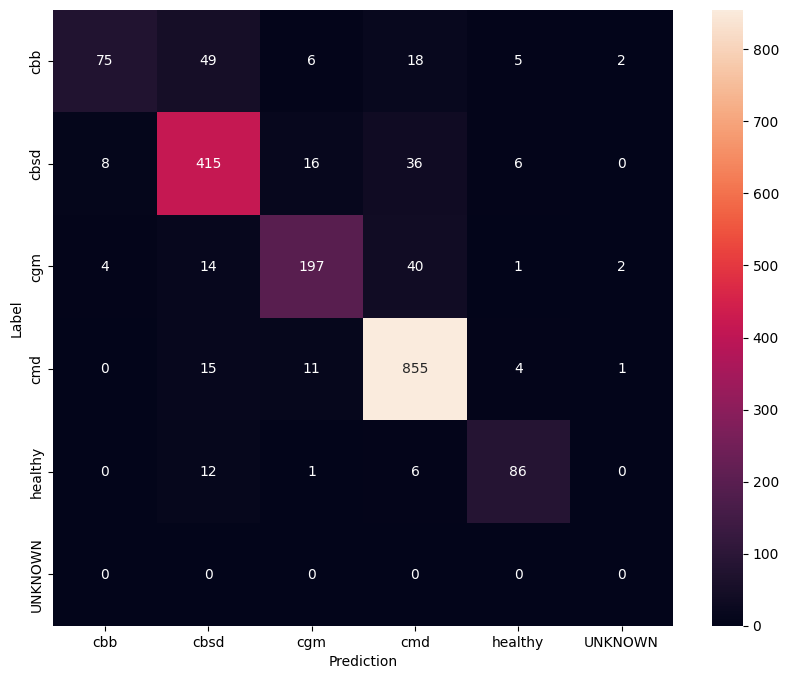

In [17]:
confusion_mtx = tf.math.confusion_matrix(
    list(ds_test.map(lambda x, y: y)),
    predict_class_label_number(test_data),
    num_classes=len(label_names))

show_confusion_matrix(confusion_mtx, label_names)

## Evaluate model on unknown test data

In this evaluation we expect the model to have accuracy of almost 1. All images the model is tested on are not related to the normal dataset and hence we expect the model to predict the "Unknown" class label.

In [18]:
model.evaluate(unknown_test_data)

  1/259 [..............................] - ETA: 6:45 - loss: 0.6763 - accuracy: 1.0000

  2/259 [..............................] - ETA: 2:24 - loss: 0.6804 - accuracy: 1.0000

  3/259 [..............................] - ETA: 1:24 - loss: 0.6796 - accuracy: 1.0000

  4/259 [..............................] - ETA: 1:04 - loss: 0.6784 - accuracy: 1.0000

  5/259 [..............................] - ETA: 54s - loss: 0.6790 - accuracy: 1.0000 

  6/259 [..............................] - ETA: 48s - loss: 0.6797 - accuracy: 1.0000

  7/259 [..............................] - ETA: 44s - loss: 0.6788 - accuracy: 1.0000

  8/259 [..............................] - ETA: 41s - loss: 0.6784 - accuracy: 1.0000

  9/259 [>.............................] - ETA: 39s - loss: 0.6782 - accuracy: 1.0000

 10/259 [>.............................] - ETA: 37s - loss: 0.6779 - accuracy: 1.0000

 11/259 [>.............................] - ETA: 36s - loss: 0.6777 - accuracy: 1.0000

 12/259 [>.............................] - ETA: 34s - loss: 0.6784 - accuracy: 1.0000

 13/259 [>.............................] - ETA: 33s - loss: 0.6783 - accuracy: 1.0000

 14/259 [>.............................] - ETA: 33s - loss: 0.6780 - accuracy: 1.0000

 15/259 [>.............................] - ETA: 32s - loss: 0.6785 - accuracy: 1.0000

 16/259 [>.............................] - ETA: 31s - loss: 0.6789 - accuracy: 1.0000

 17/259 [>.............................] - ETA: 31s - loss: 0.6790 - accuracy: 1.0000

 18/259 [=>............................] - ETA: 30s - loss: 0.6789 - accuracy: 1.0000

 19/259 [=>............................] - ETA: 30s - loss: 0.6788 - accuracy: 1.0000

 20/259 [=>............................] - ETA: 29s - loss: 0.6786 - accuracy: 1.0000

 21/259 [=>............................] - ETA: 29s - loss: 0.6785 - accuracy: 1.0000

 22/259 [=>............................] - ETA: 28s - loss: 0.6784 - accuracy: 1.0000

 23/259 [=>............................] - ETA: 28s - loss: 0.6784 - accuracy: 1.0000

 24/259 [=>............................] - ETA: 28s - loss: 0.6783 - accuracy: 1.0000

 25/259 [=>............................] - ETA: 27s - loss: 0.6782 - accuracy: 1.0000

 26/259 [==>...........................] - ETA: 27s - loss: 0.6782 - accuracy: 1.0000

 27/259 [==>...........................] - ETA: 27s - loss: 0.6781 - accuracy: 1.0000

 28/259 [==>...........................] - ETA: 27s - loss: 0.6780 - accuracy: 1.0000

 29/259 [==>...........................] - ETA: 26s - loss: 0.6785 - accuracy: 1.0000

 30/259 [==>...........................] - ETA: 26s - loss: 0.6784 - accuracy: 1.0000

 31/259 [==>...........................] - ETA: 26s - loss: 0.6783 - accuracy: 1.0000

 32/259 [==>...........................] - ETA: 26s - loss: 0.6782 - accuracy: 1.0000

 33/259 [==>...........................] - ETA: 25s - loss: 0.6782 - accuracy: 1.0000

 34/259 [==>...........................] - ETA: 25s - loss: 0.6782 - accuracy: 1.0000

 35/259 [===>..........................] - ETA: 25s - loss: 0.6782 - accuracy: 1.0000

 36/259 [===>..........................] - ETA: 25s - loss: 0.6781 - accuracy: 1.0000

 37/259 [===>..........................] - ETA: 25s - loss: 0.6780 - accuracy: 1.0000

 38/259 [===>..........................] - ETA: 24s - loss: 0.6780 - accuracy: 1.0000

 39/259 [===>..........................] - ETA: 24s - loss: 0.6780 - accuracy: 1.0000

 40/259 [===>..........................] - ETA: 24s - loss: 0.6781 - accuracy: 1.0000

 41/259 [===>..........................] - ETA: 24s - loss: 0.6780 - accuracy: 1.0000

 42/259 [===>..........................] - ETA: 24s - loss: 0.6780 - accuracy: 1.0000

 43/259 [===>..........................] - ETA: 23s - loss: 0.6780 - accuracy: 1.0000

 44/259 [====>.........................] - ETA: 23s - loss: 0.6780 - accuracy: 1.0000

 45/259 [====>.........................] - ETA: 23s - loss: 0.6780 - accuracy: 1.0000

 46/259 [====>.........................] - ETA: 23s - loss: 0.6780 - accuracy: 1.0000

 47/259 [====>.........................] - ETA: 23s - loss: 0.6782 - accuracy: 1.0000

 48/259 [====>.........................] - ETA: 23s - loss: 0.6781 - accuracy: 1.0000

 49/259 [====>.........................] - ETA: 23s - loss: 0.6781 - accuracy: 1.0000

 50/259 [====>.........................] - ETA: 22s - loss: 0.6781 - accuracy: 1.0000

 51/259 [====>.........................] - ETA: 22s - loss: 0.6781 - accuracy: 1.0000

 52/259 [=====>........................] - ETA: 22s - loss: 0.6780 - accuracy: 1.0000

 53/259 [=====>........................] - ETA: 22s - loss: 0.6781 - accuracy: 1.0000

 54/259 [=====>........................] - ETA: 22s - loss: 0.6781 - accuracy: 1.0000

 55/259 [=====>........................] - ETA: 22s - loss: 0.6781 - accuracy: 1.0000

 56/259 [=====>........................] - ETA: 22s - loss: 0.6781 - accuracy: 1.0000

 57/259 [=====>........................] - ETA: 21s - loss: 0.6781 - accuracy: 1.0000

 58/259 [=====>........................] - ETA: 21s - loss: 0.6781 - accuracy: 1.0000

 59/259 [=====>........................] - ETA: 21s - loss: 0.6781 - accuracy: 1.0000

 60/259 [=====>........................] - ETA: 21s - loss: 0.6780 - accuracy: 1.0000

 61/259 [======>.......................] - ETA: 21s - loss: 0.6780 - accuracy: 1.0000

 62/259 [======>.......................] - ETA: 21s - loss: 0.6780 - accuracy: 1.0000

 63/259 [======>.......................] - ETA: 26s - loss: 0.6779 - accuracy: 1.0000

 64/259 [======>.......................] - ETA: 26s - loss: 0.6779 - accuracy: 1.0000

 65/259 [======>.......................] - ETA: 26s - loss: 0.6778 - accuracy: 1.0000

 66/259 [======>.......................] - ETA: 25s - loss: 0.6777 - accuracy: 1.0000

 67/259 [======>.......................] - ETA: 25s - loss: 0.6777 - accuracy: 1.0000

 68/259 [======>.......................] - ETA: 25s - loss: 0.6776 - accuracy: 1.0000

 69/259 [======>.......................] - ETA: 25s - loss: 0.6776 - accuracy: 1.0000

 70/259 [=======>......................] - ETA: 24s - loss: 0.6776 - accuracy: 1.0000

 71/259 [=======>......................] - ETA: 24s - loss: 0.6776 - accuracy: 1.0000

 72/259 [=======>......................] - ETA: 24s - loss: 0.6775 - accuracy: 1.0000

 73/259 [=======>......................] - ETA: 24s - loss: 0.6775 - accuracy: 1.0000

 74/259 [=======>......................] - ETA: 24s - loss: 0.6775 - accuracy: 1.0000

 75/259 [=======>......................] - ETA: 23s - loss: 0.6774 - accuracy: 1.0000

 76/259 [=======>......................] - ETA: 23s - loss: 0.6774 - accuracy: 1.0000

 77/259 [=======>......................] - ETA: 23s - loss: 0.6774 - accuracy: 1.0000

 78/259 [========>.....................] - ETA: 23s - loss: 0.6774 - accuracy: 1.0000

 79/259 [========>.....................] - ETA: 23s - loss: 0.6774 - accuracy: 1.0000

 80/259 [========>.....................] - ETA: 22s - loss: 0.6773 - accuracy: 1.0000

 81/259 [========>.....................] - ETA: 22s - loss: 0.6773 - accuracy: 1.0000

 82/259 [========>.....................] - ETA: 22s - loss: 0.6773 - accuracy: 1.0000

 83/259 [========>.....................] - ETA: 22s - loss: 0.6772 - accuracy: 1.0000

 84/259 [========>.....................] - ETA: 22s - loss: 0.6772 - accuracy: 1.0000

 85/259 [========>.....................] - ETA: 21s - loss: 0.6772 - accuracy: 1.0000

 86/259 [========>.....................] - ETA: 21s - loss: 0.6771 - accuracy: 1.0000

 87/259 [=========>....................] - ETA: 21s - loss: 0.6771 - accuracy: 1.0000

 88/259 [=========>....................] - ETA: 21s - loss: 0.6771 - accuracy: 1.0000

 89/259 [=========>....................] - ETA: 21s - loss: 0.6771 - accuracy: 1.0000

 90/259 [=========>....................] - ETA: 20s - loss: 0.6770 - accuracy: 1.0000

 91/259 [=========>....................] - ETA: 20s - loss: 0.6770 - accuracy: 1.0000

 92/259 [=========>....................] - ETA: 20s - loss: 0.6770 - accuracy: 1.0000

 93/259 [=========>....................] - ETA: 20s - loss: 0.6770 - accuracy: 1.0000

 94/259 [=========>....................] - ETA: 20s - loss: 0.6770 - accuracy: 1.0000

 95/259 [==========>...................] - ETA: 20s - loss: 0.6769 - accuracy: 1.0000

 96/259 [==========>...................] - ETA: 19s - loss: 0.6770 - accuracy: 1.0000

 97/259 [==========>...................] - ETA: 19s - loss: 0.6769 - accuracy: 1.0000

 98/259 [==========>...................] - ETA: 19s - loss: 0.6769 - accuracy: 1.0000

 99/259 [==========>...................] - ETA: 19s - loss: 0.6769 - accuracy: 1.0000

100/259 [==========>...................] - ETA: 19s - loss: 0.6769 - accuracy: 1.0000

101/259 [==========>...................] - ETA: 19s - loss: 0.6769 - accuracy: 1.0000

102/259 [==========>...................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

103/259 [==========>...................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

104/259 [===========>..................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

105/259 [===========>..................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

106/259 [===========>..................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

107/259 [===========>..................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

108/259 [===========>..................] - ETA: 18s - loss: 0.6769 - accuracy: 1.0000

109/259 [===========>..................] - ETA: 17s - loss: 0.6769 - accuracy: 1.0000

110/259 [===========>..................] - ETA: 17s - loss: 0.6768 - accuracy: 1.0000

111/259 [===========>..................] - ETA: 17s - loss: 0.6768 - accuracy: 1.0000

112/259 [===========>..................] - ETA: 17s - loss: 0.6768 - accuracy: 1.0000

113/259 [============>.................] - ETA: 17s - loss: 0.6768 - accuracy: 1.0000

114/259 [============>.................] - ETA: 17s - loss: 0.6768 - accuracy: 1.0000

115/259 [============>.................] - ETA: 17s - loss: 0.6768 - accuracy: 1.0000

116/259 [============>.................] - ETA: 16s - loss: 0.6768 - accuracy: 1.0000

117/259 [============>.................] - ETA: 16s - loss: 0.6768 - accuracy: 1.0000

118/259 [============>.................] - ETA: 16s - loss: 0.6768 - accuracy: 1.0000

119/259 [============>.................] - ETA: 16s - loss: 0.6767 - accuracy: 1.0000

120/259 [============>.................] - ETA: 16s - loss: 0.6767 - accuracy: 1.0000

121/259 [=============>................] - ETA: 16s - loss: 0.6767 - accuracy: 1.0000

122/259 [=============>................] - ETA: 16s - loss: 0.6767 - accuracy: 1.0000

123/259 [=============>................] - ETA: 15s - loss: 0.6768 - accuracy: 1.0000

124/259 [=============>................] - ETA: 15s - loss: 0.6767 - accuracy: 1.0000

125/259 [=============>................] - ETA: 15s - loss: 0.6767 - accuracy: 1.0000

126/259 [=============>................] - ETA: 15s - loss: 0.6767 - accuracy: 1.0000

127/259 [=============>................] - ETA: 15s - loss: 0.6767 - accuracy: 1.0000

128/259 [=============>................] - ETA: 15s - loss: 0.6767 - accuracy: 1.0000

129/259 [=============>................] - ETA: 15s - loss: 0.6767 - accuracy: 1.0000

130/259 [==============>...............] - ETA: 14s - loss: 0.6766 - accuracy: 1.0000

131/259 [==============>...............] - ETA: 14s - loss: 0.6766 - accuracy: 1.0000

132/259 [==============>...............] - ETA: 14s - loss: 0.6766 - accuracy: 1.0000

133/259 [==============>...............] - ETA: 14s - loss: 0.6766 - accuracy: 1.0000

134/259 [==============>...............] - ETA: 14s - loss: 0.6767 - accuracy: 1.0000

135/259 [==============>...............] - ETA: 14s - loss: 0.6766 - accuracy: 1.0000

136/259 [==============>...............] - ETA: 14s - loss: 0.6767 - accuracy: 1.0000

137/259 [==============>...............] - ETA: 14s - loss: 0.6766 - accuracy: 1.0000

138/259 [==============>...............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

139/259 [===============>..............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

140/259 [===============>..............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

141/259 [===============>..............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

142/259 [===============>..............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

143/259 [===============>..............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

144/259 [===============>..............] - ETA: 13s - loss: 0.6766 - accuracy: 1.0000

145/259 [===============>..............] - ETA: 12s - loss: 0.6766 - accuracy: 1.0000

146/259 [===============>..............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

147/259 [================>.............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

148/259 [================>.............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

149/259 [================>.............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

150/259 [================>.............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

151/259 [================>.............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

152/259 [================>.............] - ETA: 12s - loss: 0.6765 - accuracy: 1.0000

153/259 [================>.............] - ETA: 11s - loss: 0.6765 - accuracy: 1.0000

154/259 [================>.............] - ETA: 11s - loss: 0.6765 - accuracy: 1.0000

155/259 [================>.............] - ETA: 11s - loss: 0.6765 - accuracy: 1.0000

156/259 [=================>............] - ETA: 11s - loss: 0.6765 - accuracy: 1.0000

157/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

158/259 [=================>............] - ETA: 11s - loss: 0.6765 - accuracy: 1.0000

159/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

160/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

161/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

162/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

163/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

164/259 [=================>............] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

165/259 [==================>...........] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

166/259 [==================>...........] - ETA: 11s - loss: 0.6764 - accuracy: 1.0000

167/259 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

168/259 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

169/259 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

170/259 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

171/259 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

172/259 [==================>...........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

173/259 [===================>..........] - ETA: 10s - loss: 0.6764 - accuracy: 1.0000

174/259 [===================>..........] - ETA: 10s - loss: 0.6763 - accuracy: 1.0000

175/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000 

176/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

177/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

178/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

179/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

180/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

181/259 [===================>..........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

182/259 [====================>.........] - ETA: 9s - loss: 0.6763 - accuracy: 1.0000

183/259 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 1.0000

184/259 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 1.0000

185/259 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 1.0000

186/259 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 1.0000

187/259 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 1.0000

188/259 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 1.0000

189/259 [====================>.........] - ETA: 8s - loss: 0.6762 - accuracy: 1.0000

190/259 [=====================>........] - ETA: 8s - loss: 0.6762 - accuracy: 1.0000

191/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

192/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

193/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

194/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

195/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

196/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

197/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

198/259 [=====================>........] - ETA: 7s - loss: 0.6762 - accuracy: 1.0000

199/259 [======================>.......] - ETA: 6s - loss: 0.6762 - accuracy: 1.0000

200/259 [======================>.......] - ETA: 6s - loss: 0.6762 - accuracy: 1.0000

201/259 [======================>.......] - ETA: 6s - loss: 0.6762 - accuracy: 1.0000

202/259 [======================>.......] - ETA: 6s - loss: 0.6762 - accuracy: 1.0000

203/259 [======================>.......] - ETA: 6s - loss: 0.6762 - accuracy: 1.0000

204/259 [======================>.......] - ETA: 6s - loss: 0.6762 - accuracy: 1.0000

205/259 [======================>.......] - ETA: 6s - loss: 0.6761 - accuracy: 1.0000

206/259 [======================>.......] - ETA: 6s - loss: 0.6761 - accuracy: 1.0000

207/259 [======================>.......] - ETA: 5s - loss: 0.6761 - accuracy: 1.0000

208/259 [=======================>......] - ETA: 5s - loss: 0.6763 - accuracy: 0.9998

209/259 [=======================>......] - ETA: 5s - loss: 0.6763 - accuracy: 0.9999

210/259 [=======================>......] - ETA: 5s - loss: 0.6763 - accuracy: 0.9999

211/259 [=======================>......] - ETA: 5s - loss: 0.6763 - accuracy: 0.9999

212/259 [=======================>......] - ETA: 5s - loss: 0.6763 - accuracy: 0.9999

213/259 [=======================>......] - ETA: 5s - loss: 0.6763 - accuracy: 0.9999

214/259 [=======================>......] - ETA: 5s - loss: 0.6762 - accuracy: 0.9999

215/259 [=======================>......] - ETA: 5s - loss: 0.6762 - accuracy: 0.9999

216/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

217/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

218/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

219/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

220/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

221/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

222/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

223/259 [========================>.....] - ETA: 4s - loss: 0.6762 - accuracy: 0.9999

224/259 [========================>.....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

225/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

226/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

227/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

228/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

229/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

230/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

231/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

232/259 [=========================>....] - ETA: 3s - loss: 0.6762 - accuracy: 0.9999

233/259 [=========================>....] - ETA: 2s - loss: 0.6762 - accuracy: 0.9999

234/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

235/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

236/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

237/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

238/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

239/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

240/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

241/259 [==========================>...] - ETA: 2s - loss: 0.6761 - accuracy: 0.9999

242/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

243/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

244/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

245/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

246/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

247/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

248/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

249/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

250/259 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.9999

251/259 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.9999

252/259 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.9999

253/259 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.9999

254/259 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.9999

255/259 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.9999

256/259 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.9999

257/259 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.9999

258/259 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.9999

259/259 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.9999

259/259 [==============================] - 30s 111ms/step - loss: 0.6760 - accuracy: 0.9999


[0.6760221719741821, 0.9998791813850403]

Print the confusion matrix.

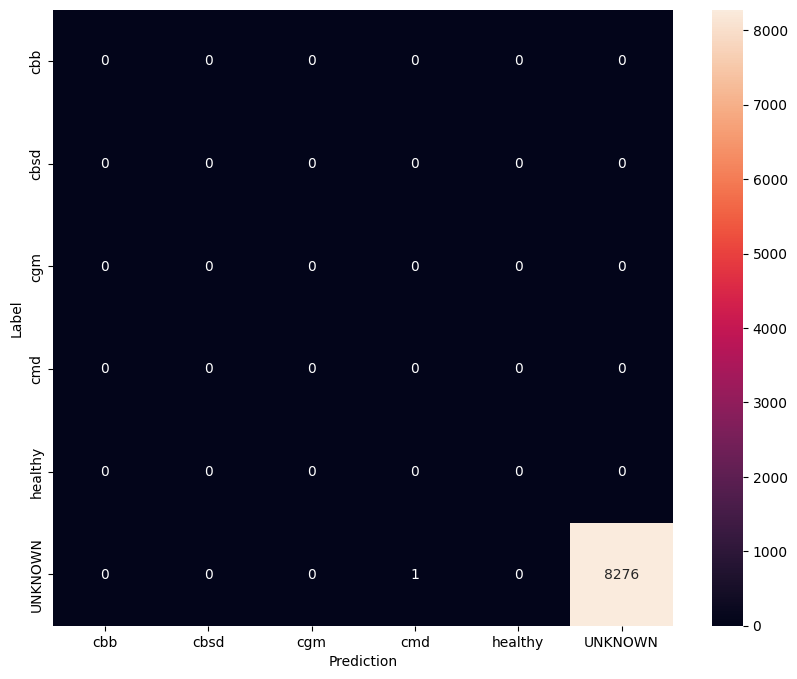

In [19]:
unknown_confusion_mtx = tf.math.confusion_matrix(
    list(ds_unknown_test.map(lambda x, y: y)),
    predict_class_label_number(unknown_test_data),
    num_classes=len(label_names))

show_confusion_matrix(unknown_confusion_mtx, label_names)

## Export the model as TFLite and SavedModel

Now we can export the trained models in TFLite and SavedModel formats for deploying on-device and using for inference in TensorFlow.

In [20]:
tflite_filename = f'{TFLITE_NAME_PREFIX}_model_{model_name}.tflite'
model.export(export_dir='.', tflite_filename=tflite_filename)

2023-11-07 14:20:20.089818: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp99qci6gx/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp99qci6gx/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


2023-11-07 14:20:30.245779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-11-07 14:20:30.245840: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmp8co343h3/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmp8co343h3/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./cassava_model_mobilenet_v3_large_100_224.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./cassava_model_mobilenet_v3_large_100_224.tflite


In [21]:
# Export saved model version.
model.export(export_dir='.', export_format=ExportFormat.SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


## Next steps

The model that you've just trained can be used on mobile devices and even deployed in the field!

**To download the model, click the folder icon for the Files menu on the left side of the colab, and choose the download option.**

The same technique used here could be applied to other plant diseases tasks that might be more suitable for your use case or any other type of image classification task. If you want to follow up and deploy on an Android app, you can continue on this [Android quickstart guide](https://www.tensorflow.org/lite/android/quickstart).